# Question 1

In [3]:
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import Callback
from keras import backend as K


In [4]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainX = np.float32(trainX/255.0)
testX = np.float32(testX/255.0)

170498071/170498071 [==============================] - 11s 0us/step


In [5]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
model_base = Sequential()
model_base.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_base.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_base.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_base.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Flatten())
model_base.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_base.add(Dense(10, activation='softmax'))
opt_base = SGD(learning_rate=0.001, momentum=0.9)
model_base.compile(optimizer=opt_base, loss='categorical_crossentropy', metrics=['accuracy'])
tc_base = TimeHistory()
model_base.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_base])

Epoch 1/10
782/782 - 11s - loss: 1.7386 - accuracy: 0.3679 - val_loss: 1.4441 - val_accuracy: 0.4847 - 11s/epoch - 14ms/step
Epoch 2/10
782/782 - 5s - loss: 1.3671 - accuracy: 0.5107 - val_loss: 1.2614 - val_accuracy: 0.5495 - 5s/epoch - 6ms/step
Epoch 3/10
782/782 - 5s - loss: 1.1818 - accuracy: 0.5814 - val_loss: 1.1022 - val_accuracy: 0.6141 - 5s/epoch - 6ms/step
Epoch 4/10
782/782 - 5s - loss: 1.0509 - accuracy: 0.6294 - val_loss: 1.0345 - val_accuracy: 0.6372 - 5s/epoch - 6ms/step
Epoch 5/10
782/782 - 5s - loss: 0.9417 - accuracy: 0.6735 - val_loss: 0.9670 - val_accuracy: 0.6594 - 5s/epoch - 6ms/step
Epoch 6/10
782/782 - 5s - loss: 0.8578 - accuracy: 0.7026 - val_loss: 0.9405 - val_accuracy: 0.6720 - 5s/epoch - 6ms/step
Epoch 7/10
782/782 - 5s - loss: 0.7858 - accuracy: 0.7287 - val_loss: 0.8980 - val_accuracy: 0.6871 - 5s/epoch - 6ms/step
Epoch 8/10
782/782 - 5s - loss: 0.7201 - accuracy: 0.7498 - val_loss: 0.8518 - val_accuracy: 0.7049 - 5s/epoch - 6ms/step
Epoch 9/10
782/782 - 

In [7]:
def evaluate_model(myModel,myTc):
  def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

  def f1_m(y_true, y_pred):
      precision = precision_m(y_true, y_pred)
      recall = recall_m(y_true, y_pred)
      return 2*((precision*recall)/(precision+recall+K.epsilon()))
  
  print("Model created, with", str(len(myModel.layers)),"layers.")
  print([layer.name for layer in myModel.layers])
  y_pred = myModel.predict(testX, verbose=0)
  _, acc = myModel.evaluate(testX, testY, verbose=0)
  print('Accuracy: %.3f' % (acc * 100.0))
  print('F1 score: %.3f' % (f1_m(testY,y_pred)))
  print("Time taken:", np.sum(myTc.times),"seconds")

evaluate_model(model_base,tc_base)

Model created, with 12 layers.
['conv2d', 'conv2d_1', 'max_pooling2d', 'conv2d_2', 'conv2d_3', 'max_pooling2d_1', 'conv2d_4', 'conv2d_5', 'max_pooling2d_2', 'flatten', 'dense', 'dense_1']
Accuracy: 71.350
F1 score: 0.716
Time taken: 54.299983501434326 seconds


# Question 2

In [8]:
def getmap(myModel,layerIdx,imgIdx=1):
    tempmodel = Model(inputs=myModel.inputs , outputs=myModel.layers[layerIdx].output)
    features = tempmodel.predict(np.expand_dims(testX[imgIdx]*255, axis=0))
    ncol = min(8,int(np.floor(np.sqrt(features.shape[3]))))
    fig, ax = plt.subplots(ncol, ncol,figsize=(2*ncol,ncol*1.5))
    if ncol == 1:
        ax.imshow(features[0,:,:,0],cmap="gray")
    else:
        count = 0
        for i in range(ncol):
            for j in range(ncol):
                ax[j,i].imshow(features[0,:,:,count],cmap="gray")
                ax[j,i].axis("off")
                count += 1
    plt.tight_layout()
    plt.show()


# Q3-A

### Decreasing CNN layers

Epoch 1/10
782/782 - 4s - loss: 1.7997 - accuracy: 0.3625 - val_loss: 1.6436 - val_accuracy: 0.4155 - 4s/epoch - 6ms/step
Epoch 2/10
782/782 - 3s - loss: 1.5214 - accuracy: 0.4658 - val_loss: 1.4718 - val_accuracy: 0.4769 - 3s/epoch - 4ms/step
Epoch 3/10
782/782 - 3s - loss: 1.3715 - accuracy: 0.5148 - val_loss: 1.3357 - val_accuracy: 0.5230 - 3s/epoch - 4ms/step
Epoch 4/10
782/782 - 3s - loss: 1.2783 - accuracy: 0.5500 - val_loss: 1.2949 - val_accuracy: 0.5454 - 3s/epoch - 4ms/step
Epoch 5/10
782/782 - 3s - loss: 1.2133 - accuracy: 0.5753 - val_loss: 1.2510 - val_accuracy: 0.5633 - 3s/epoch - 4ms/step
Epoch 6/10
782/782 - 3s - loss: 1.1645 - accuracy: 0.5931 - val_loss: 1.2208 - val_accuracy: 0.5695 - 3s/epoch - 4ms/step
Epoch 7/10
782/782 - 3s - loss: 1.1162 - accuracy: 0.6118 - val_loss: 1.1892 - val_accuracy: 0.5771 - 3s/epoch - 4ms/step
Epoch 8/10
782/782 - 3s - loss: 1.0741 - accuracy: 0.6259 - val_loss: 1.1908 - val_accuracy: 0.5800 - 3s/epoch - 4ms/step
Epoch 9/10
782/782 - 3s 

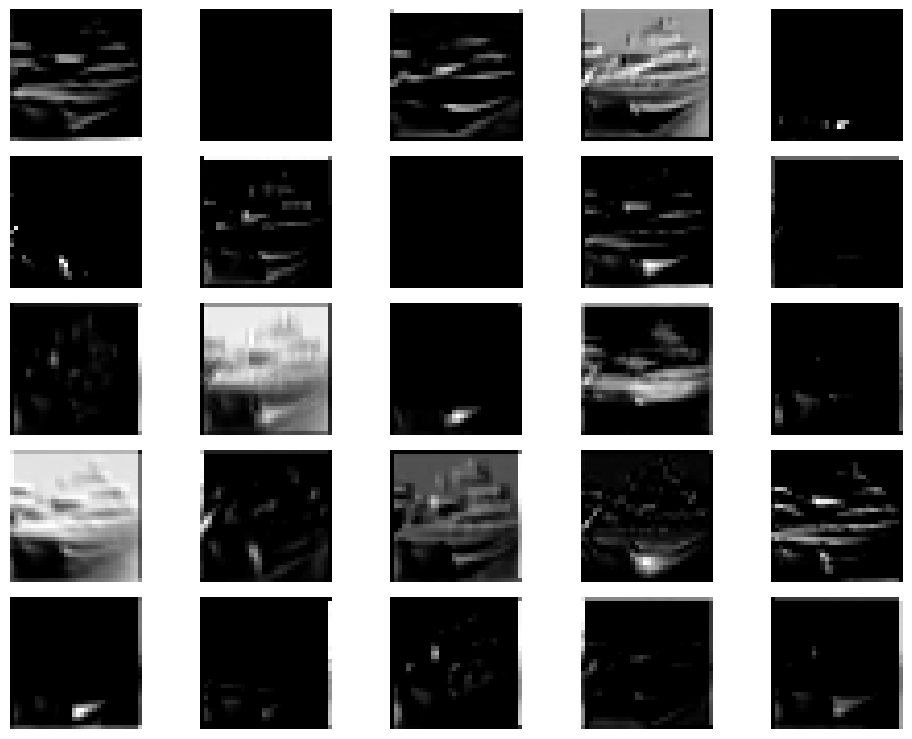

In [9]:
model_nocnn = Sequential()
model_nocnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_nocnn.add(Flatten())
model_nocnn.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_nocnn.add(Dense(10, activation='softmax'))
opt_nocnn = SGD(learning_rate=0.001, momentum=0.9)
tc_nocnn = TimeHistory()
model_nocnn.compile(optimizer=opt_nocnn, loss='categorical_crossentropy', metrics=['accuracy'])
model_nocnn.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_nocnn])

evaluate_model(model_nocnn,tc_nocnn)
getmap(model_nocnn,0)

### Increasing CNN Layers


In [14]:
model_ultracnn = Sequential()
model_ultracnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_ultracnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Flatten())
model_ultracnn.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_ultracnn.add(Dense(10, activation='softmax'))
opt_ultracnn = SGD(learning_rate=0.001, momentum=0.9)
tc_ultracnn = TimeHistory()
model_ultracnn.compile(optimizer=opt_ultracnn, loss='categorical_crossentropy', metrics=['accuracy'])
model_ultracnn.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_ultracnn])
evaluate_model(model_ultracnn,tc_ultracnn)

Epoch 1/10
782/782 - 7s - loss: 1.8246 - accuracy: 0.3367 - val_loss: 1.8189 - val_accuracy: 0.3433 - 7s/epoch - 8ms/step
Epoch 2/10
782/782 - 6s - loss: 1.4620 - accuracy: 0.4694 - val_loss: 1.3989 - val_accuracy: 0.4885 - 6s/epoch - 7ms/step
Epoch 3/10
782/782 - 5s - loss: 1.2994 - accuracy: 0.5308 - val_loss: 1.2403 - val_accuracy: 0.5511 - 5s/epoch - 7ms/step
Epoch 4/10
782/782 - 6s - loss: 1.1692 - accuracy: 0.5807 - val_loss: 1.1801 - val_accuracy: 0.5671 - 6s/epoch - 7ms/step
Epoch 5/10
782/782 - 5s - loss: 1.0668 - accuracy: 0.6189 - val_loss: 1.0877 - val_accuracy: 0.6144 - 5s/epoch - 7ms/step
Epoch 6/10
782/782 - 6s - loss: 0.9913 - accuracy: 0.6487 - val_loss: 1.0522 - val_accuracy: 0.6248 - 6s/epoch - 7ms/step
Epoch 7/10
782/782 - 5s - loss: 0.9152 - accuracy: 0.6745 - val_loss: 0.9972 - val_accuracy: 0.6493 - 5s/epoch - 7ms/step
Epoch 8/10
782/782 - 6s - loss: 0.8543 - accuracy: 0.6962 - val_loss: 0.9381 - val_accuracy: 0.6691 - 6s/epoch - 7ms/step
Epoch 9/10
782/782 - 5s 

1/1 [==============================] - 0s 399ms/step


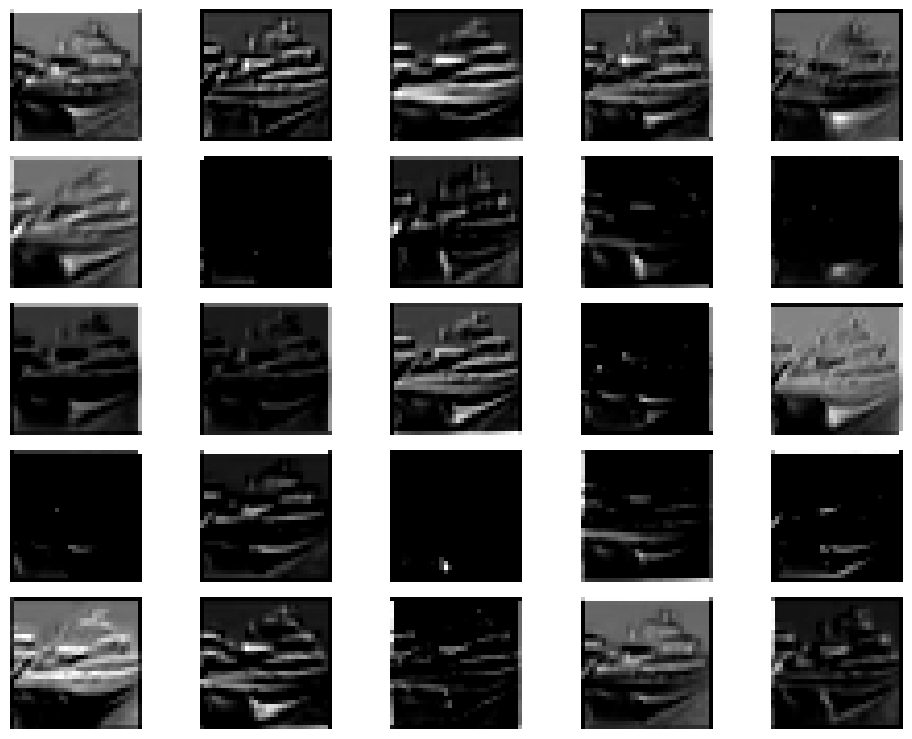

1/1 [==============================] - 0s 133ms/step


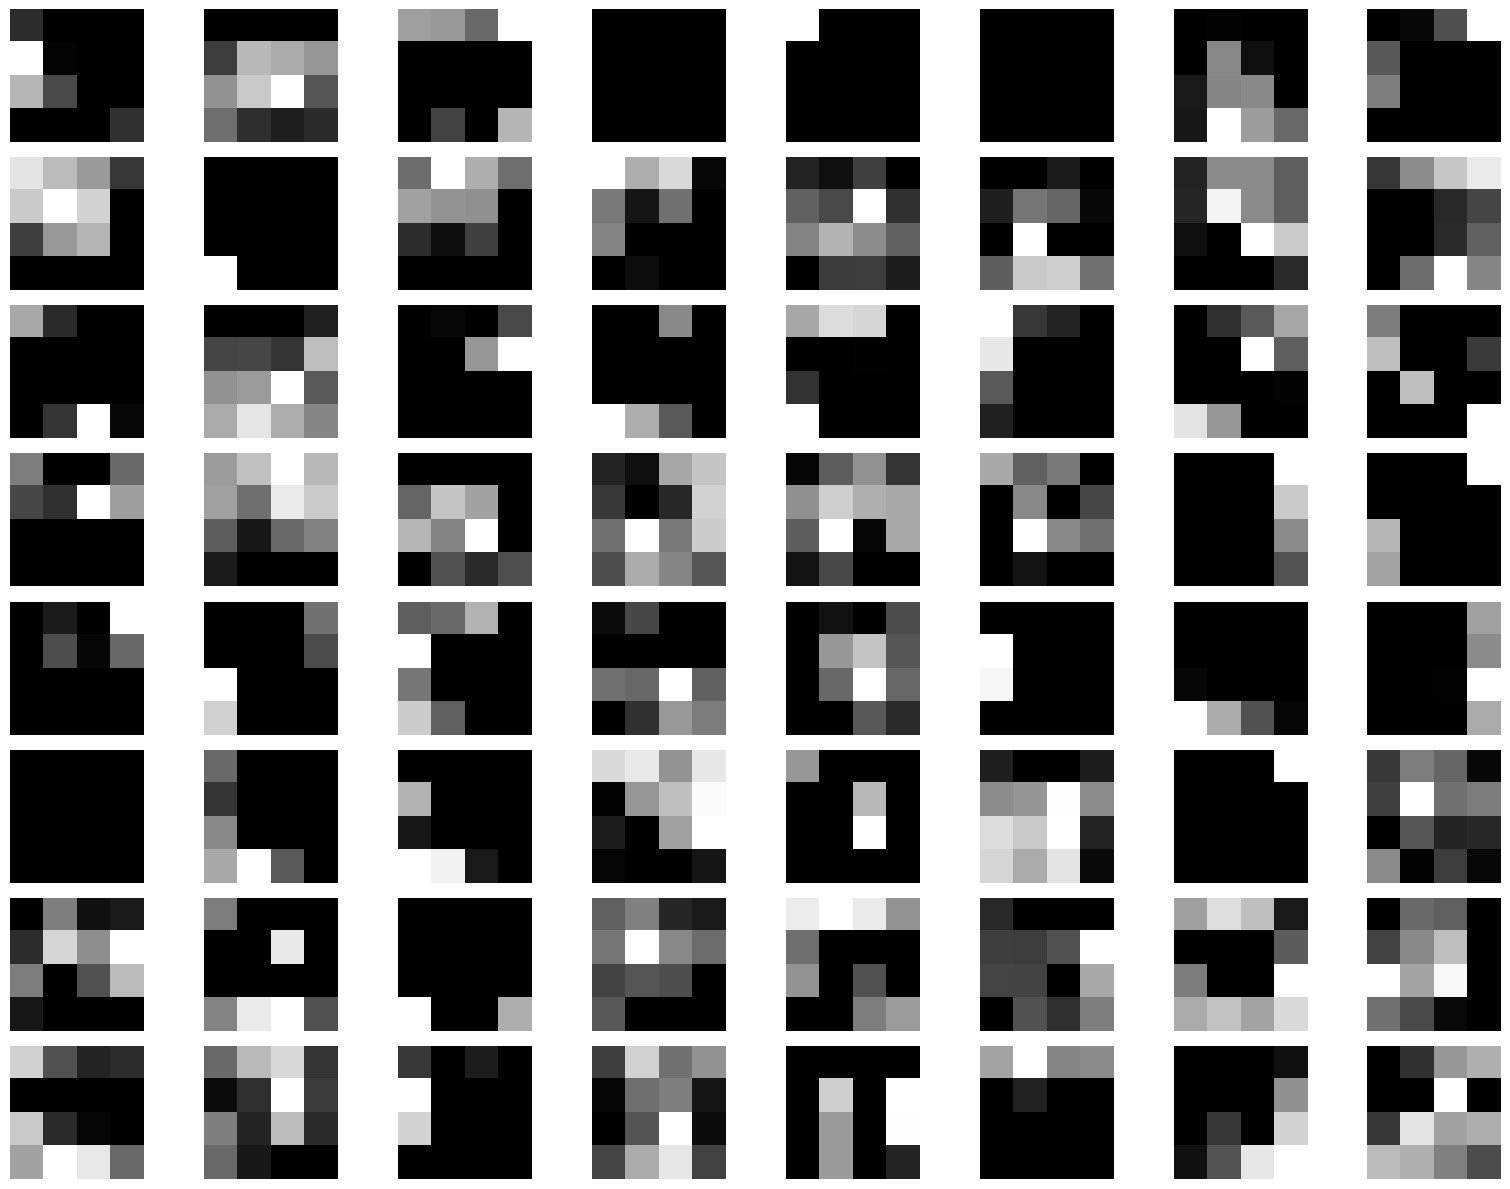

1/1 [==============================] - 0s 133ms/step


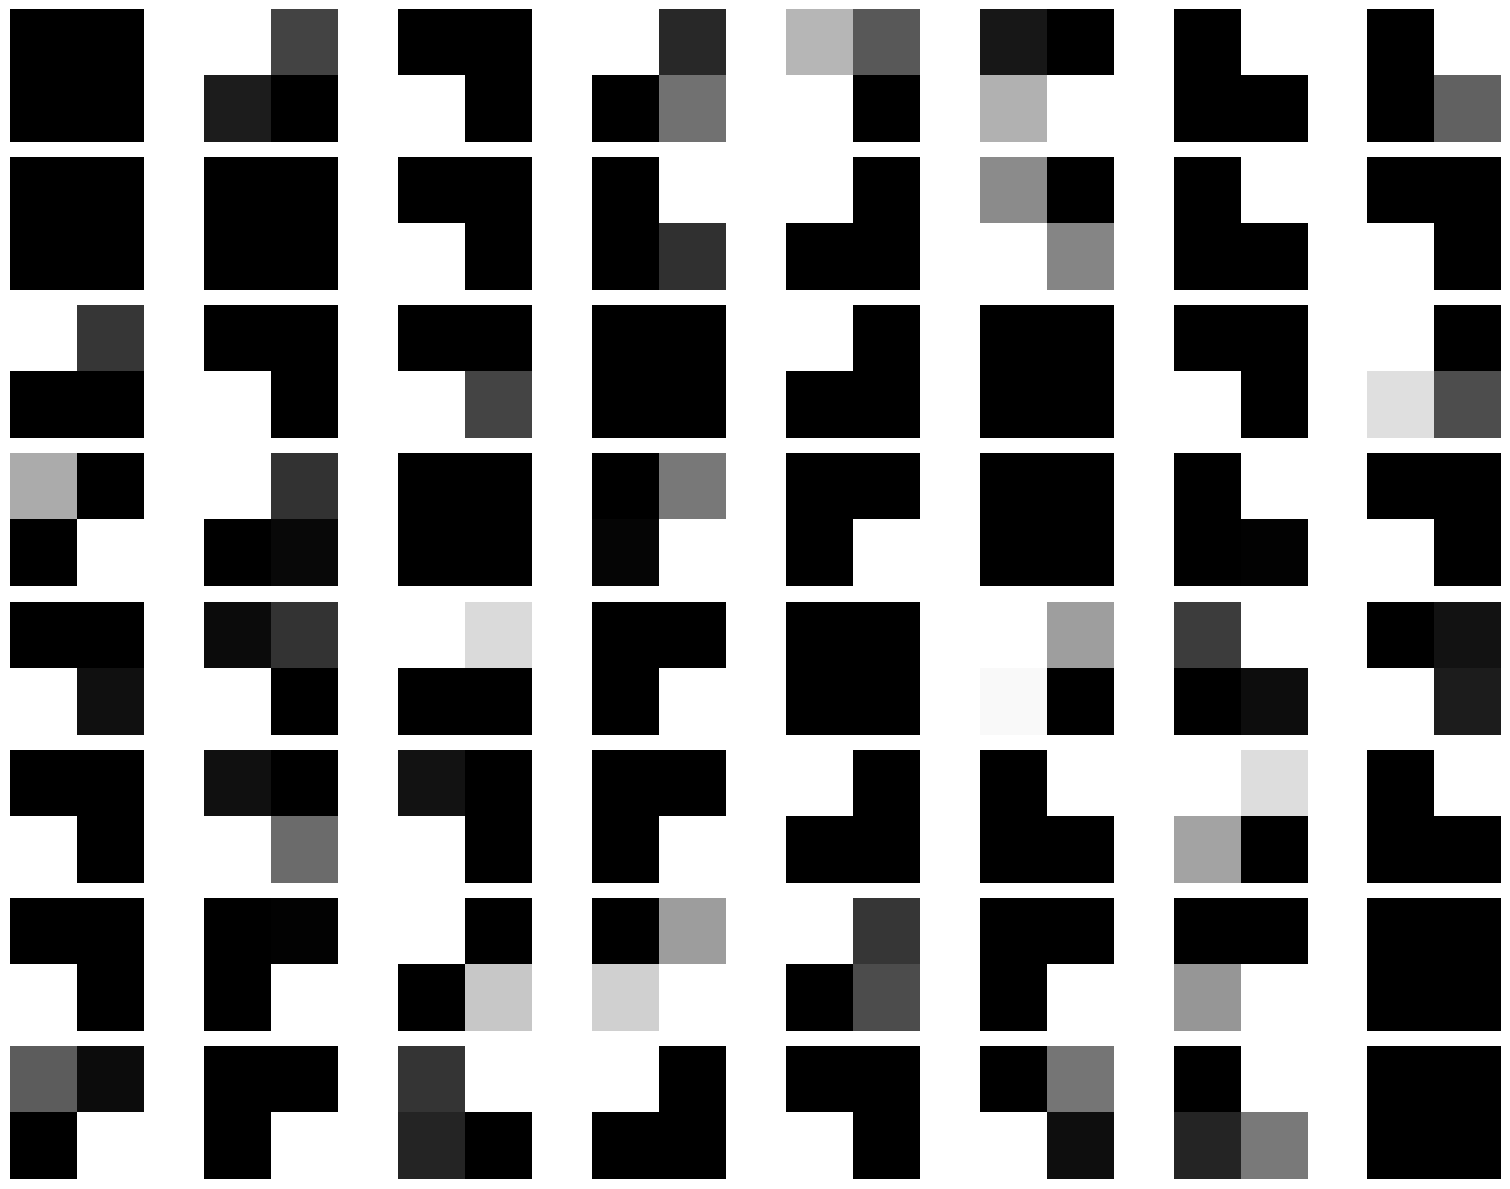

In [15]:
getmap(model_ultracnn,0)
getmap(model_ultracnn,9)
getmap(model_ultracnn,13)

### Increasing CNN layers + Number of Filters

In [37]:
model_ultracnn = Sequential()
model_ultracnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_ultracnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultracnn.add(MaxPooling2D((2, 2)))
model_ultracnn.add(Flatten())
model_ultracnn.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_ultracnn.add(Dense(10, activation='softmax'))
opt_ultracnn = SGD(learning_rate=0.001, momentum=0.9)
tc_ultracnn = TimeHistory()
model_ultracnn.compile(optimizer=opt_ultracnn, loss='categorical_crossentropy', metrics=['accuracy'])
model_ultracnn.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_ultracnn])
evaluate_model(model_ultracnn,tc_ultracnn)

Epoch 1/10
782/782 - 7s - loss: 1.7307 - accuracy: 0.3691 - val_loss: 1.4637 - val_accuracy: 0.4704 - 7s/epoch - 9ms/step
Epoch 2/10
782/782 - 6s - loss: 1.3613 - accuracy: 0.5095 - val_loss: 1.2708 - val_accuracy: 0.5412 - 6s/epoch - 7ms/step
Epoch 3/10
782/782 - 6s - loss: 1.1824 - accuracy: 0.5793 - val_loss: 1.2157 - val_accuracy: 0.5558 - 6s/epoch - 7ms/step
Epoch 4/10
782/782 - 6s - loss: 1.0445 - accuracy: 0.6332 - val_loss: 1.0498 - val_accuracy: 0.6299 - 6s/epoch - 7ms/step
Epoch 5/10
782/782 - 6s - loss: 0.9365 - accuracy: 0.6723 - val_loss: 0.9939 - val_accuracy: 0.6507 - 6s/epoch - 7ms/step
Epoch 6/10
782/782 - 6s - loss: 0.8393 - accuracy: 0.7066 - val_loss: 0.8949 - val_accuracy: 0.6867 - 6s/epoch - 7ms/step
Epoch 7/10
782/782 - 6s - loss: 0.7577 - accuracy: 0.7371 - val_loss: 0.8705 - val_accuracy: 0.6974 - 6s/epoch - 8ms/step
Epoch 8/10
782/782 - 6s - loss: 0.6865 - accuracy: 0.7613 - val_loss: 0.8406 - val_accuracy: 0.7116 - 6s/epoch - 7ms/step
Epoch 9/10
782/782 - 6s 

### Increasing MLP layers

In [17]:
model_ultramlp = Sequential()
model_ultramlp.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_ultramlp.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultramlp.add(MaxPooling2D((2, 2)))
model_ultramlp.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultramlp.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultramlp.add(MaxPooling2D((2, 2)))
model_ultramlp.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultramlp.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_ultramlp.add(MaxPooling2D((2, 2)))
model_ultramlp.add(Flatten())
model_ultramlp.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp.add(Dense(10, activation='softmax'))
opt_ultramlp = SGD(learning_rate=0.001, momentum=0.9)
tc_ultramlp = TimeHistory()
model_ultramlp.compile(optimizer=opt_ultramlp, loss='categorical_crossentropy', metrics=['accuracy'])
model_ultramlp.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_ultramlp])
evaluate_model(model_ultramlp,tc_ultramlp)

Epoch 1/10
782/782 - 6s - loss: 1.8806 - accuracy: 0.2878 - val_loss: 1.5702 - val_accuracy: 0.4170 - 6s/epoch - 8ms/step
Epoch 2/10
782/782 - 5s - loss: 1.5018 - accuracy: 0.4496 - val_loss: 1.5124 - val_accuracy: 0.4645 - 5s/epoch - 7ms/step
Epoch 3/10
782/782 - 5s - loss: 1.3072 - accuracy: 0.5257 - val_loss: 1.2206 - val_accuracy: 0.5619 - 5s/epoch - 6ms/step
Epoch 4/10
782/782 - 5s - loss: 1.1691 - accuracy: 0.5806 - val_loss: 1.2246 - val_accuracy: 0.5692 - 5s/epoch - 6ms/step
Epoch 5/10
782/782 - 5s - loss: 1.0524 - accuracy: 0.6258 - val_loss: 1.0782 - val_accuracy: 0.6229 - 5s/epoch - 6ms/step
Epoch 6/10
782/782 - 5s - loss: 0.9677 - accuracy: 0.6551 - val_loss: 1.0157 - val_accuracy: 0.6485 - 5s/epoch - 6ms/step
Epoch 7/10
782/782 - 5s - loss: 0.8866 - accuracy: 0.6867 - val_loss: 0.9783 - val_accuracy: 0.6521 - 5s/epoch - 6ms/step
Epoch 8/10
782/782 - 5s - loss: 0.8165 - accuracy: 0.7128 - val_loss: 0.9577 - val_accuracy: 0.6658 - 5s/epoch - 6ms/step
Epoch 9/10
782/782 - 5s 

1/1 [==============================] - 0s 39ms/step


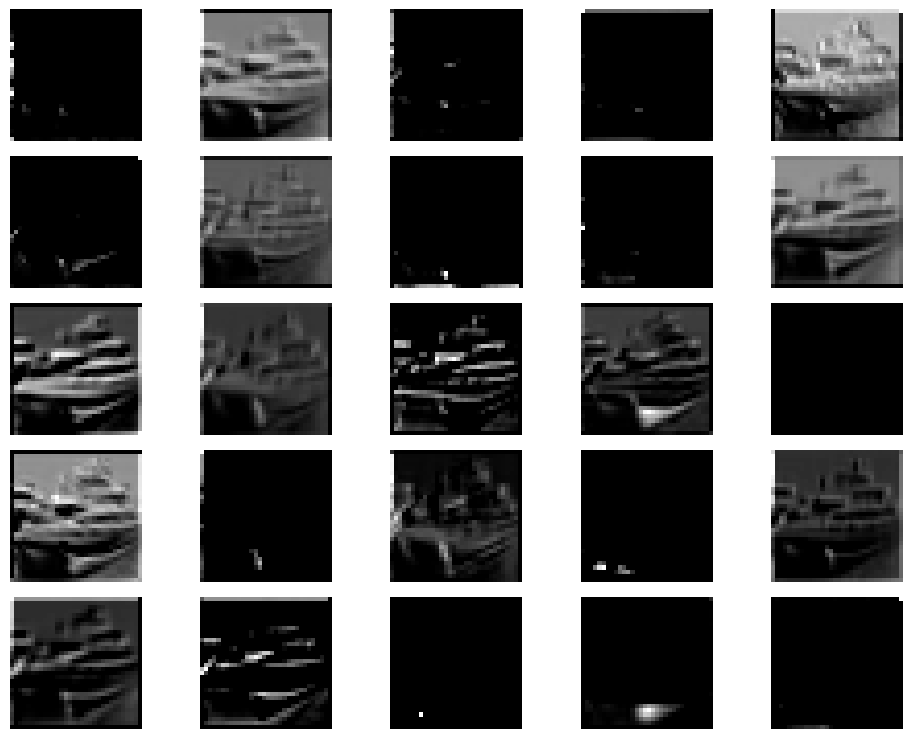

1/1 [==============================] - 0s 69ms/step


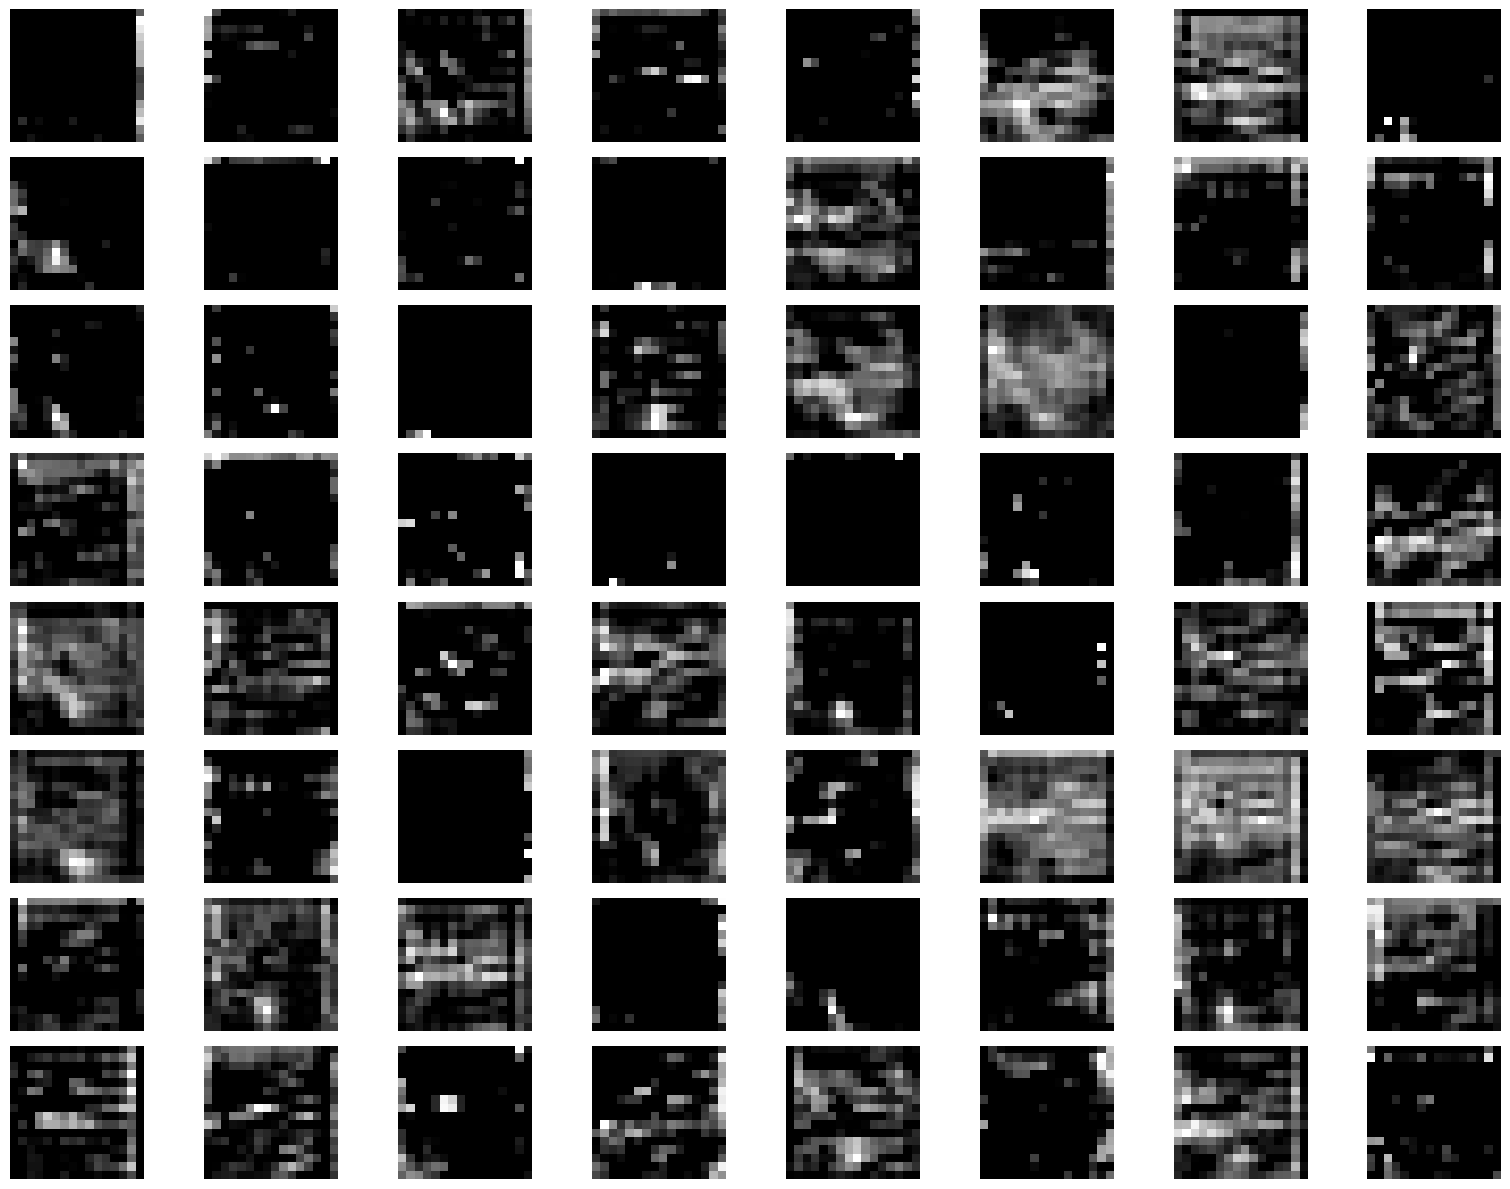

1/1 [==============================] - 0s 98ms/step


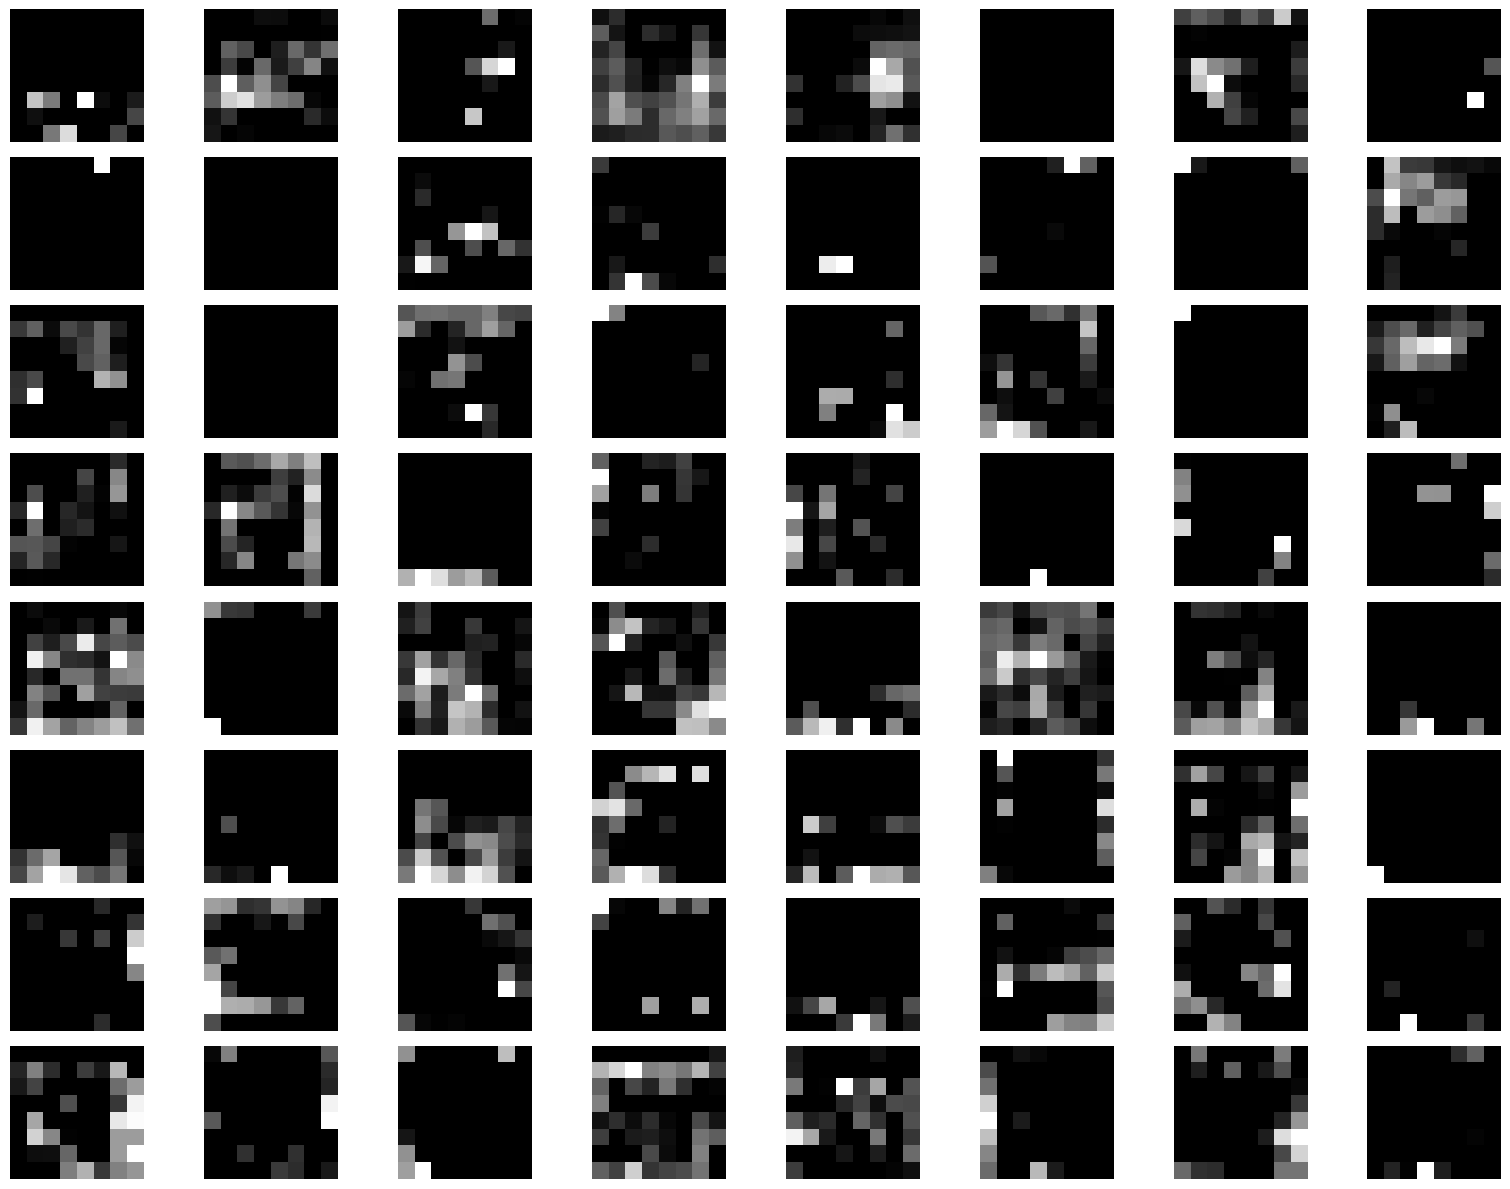

In [18]:
getmap(model_ultramlp,0)
getmap(model_ultramlp,4)
getmap(model_ultramlp,7)

### Increasing MLP Layers while decreasing CNN

In [19]:
model_ultramlp_nocnn = Sequential()
model_ultramlp_nocnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_ultramlp_nocnn.add(MaxPooling2D((2, 2)))
model_ultramlp_nocnn.add(Flatten())
model_ultramlp_nocnn.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp_nocnn.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp_nocnn.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp_nocnn.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
model_ultramlp_nocnn.add(Dense(10, activation='softmax'))
opt_ultramlp_nocnn = SGD(learning_rate=0.001, momentum=0.9)
tc_ultramlp_nocnn = TimeHistory()
model_ultramlp_nocnn.compile(optimizer=opt_ultramlp_nocnn, loss='categorical_crossentropy', metrics=['accuracy'])
model_ultramlp_nocnn.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_ultramlp_nocnn])
evaluate_model(model_ultramlp_nocnn,tc_ultramlp_nocnn)

Epoch 1/10
782/782 - 4s - loss: 1.9024 - accuracy: 0.3113 - val_loss: 1.6769 - val_accuracy: 0.3972 - 4s/epoch - 5ms/step
Epoch 2/10
782/782 - 3s - loss: 1.5210 - accuracy: 0.4480 - val_loss: 1.4127 - val_accuracy: 0.4889 - 3s/epoch - 4ms/step
Epoch 3/10
782/782 - 3s - loss: 1.3730 - accuracy: 0.5043 - val_loss: 1.3343 - val_accuracy: 0.5211 - 3s/epoch - 4ms/step
Epoch 4/10
782/782 - 3s - loss: 1.2766 - accuracy: 0.5426 - val_loss: 1.2424 - val_accuracy: 0.5558 - 3s/epoch - 4ms/step
Epoch 5/10
782/782 - 3s - loss: 1.1971 - accuracy: 0.5696 - val_loss: 1.1885 - val_accuracy: 0.5724 - 3s/epoch - 4ms/step
Epoch 6/10
782/782 - 3s - loss: 1.1271 - accuracy: 0.5970 - val_loss: 1.1540 - val_accuracy: 0.5844 - 3s/epoch - 4ms/step
Epoch 7/10
782/782 - 3s - loss: 1.0709 - accuracy: 0.6166 - val_loss: 1.1442 - val_accuracy: 0.5923 - 3s/epoch - 3ms/step
Epoch 8/10
782/782 - 3s - loss: 1.0228 - accuracy: 0.6340 - val_loss: 1.1176 - val_accuracy: 0.6055 - 3s/epoch - 4ms/step
Epoch 9/10
782/782 - 3s 

1/1 [==============================] - 0s 38ms/step


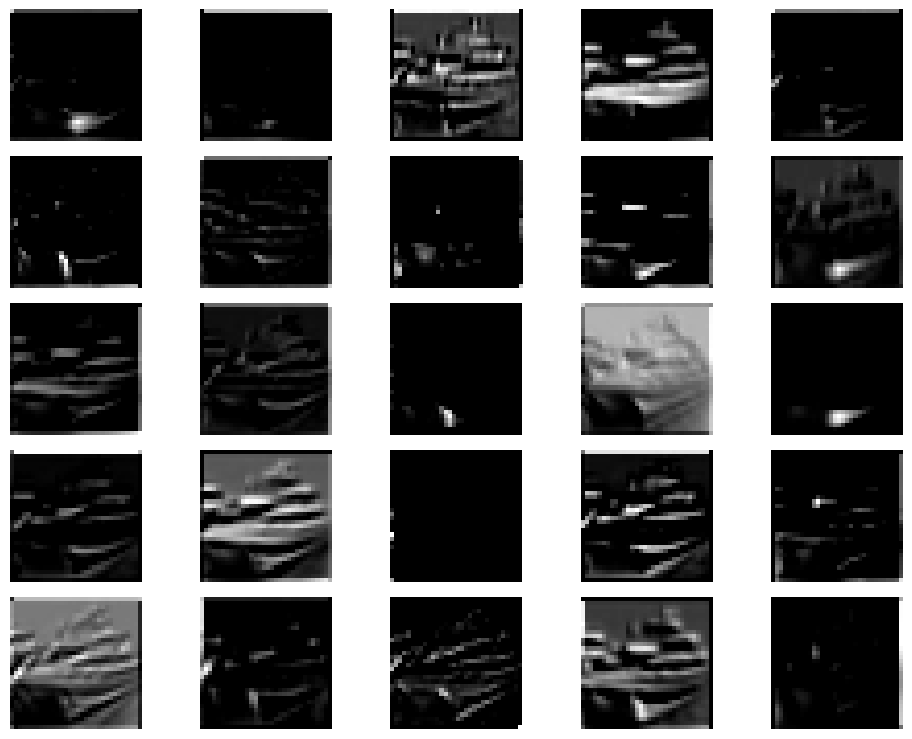

In [20]:
getmap(model_ultramlp_nocnn,0)

# Q3-B

### 5x5 Filters throughout

In [21]:
model_bigfilter = Sequential()
model_bigfilter.add(Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_bigfilter.add(Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_bigfilter.add(MaxPooling2D((2, 2)))
model_bigfilter.add(Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_bigfilter.add(Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_bigfilter.add(MaxPooling2D((2, 2)))
model_bigfilter.add(Conv2D(128, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_bigfilter.add(Conv2D(128, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_bigfilter.add(MaxPooling2D((2, 2)))
model_bigfilter.add(Flatten())
model_bigfilter.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_bigfilter.add(Dense(10, activation='softmax'))
opt_bigfilter = SGD(learning_rate=0.001, momentum=0.9)
model_bigfilter.compile(optimizer=opt_bigfilter, loss='categorical_crossentropy', metrics=['accuracy'])
tc_bigfilter = TimeHistory()
model_bigfilter.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_bigfilter])
evaluate_model(model_bigfilter,tc_bigfilter)

Epoch 1/10
782/782 - 9s - loss: 1.7400 - accuracy: 0.3733 - val_loss: 1.5076 - val_accuracy: 0.4565 - 9s/epoch - 11ms/step
Epoch 2/10
782/782 - 8s - loss: 1.3863 - accuracy: 0.5044 - val_loss: 1.2973 - val_accuracy: 0.5280 - 8s/epoch - 10ms/step
Epoch 3/10
782/782 - 7s - loss: 1.2287 - accuracy: 0.5630 - val_loss: 1.3108 - val_accuracy: 0.5382 - 7s/epoch - 10ms/step
Epoch 4/10
782/782 - 8s - loss: 1.1056 - accuracy: 0.6106 - val_loss: 1.1543 - val_accuracy: 0.5922 - 8s/epoch - 10ms/step
Epoch 5/10
782/782 - 8s - loss: 0.9961 - accuracy: 0.6482 - val_loss: 1.0845 - val_accuracy: 0.6256 - 8s/epoch - 10ms/step
Epoch 6/10
782/782 - 8s - loss: 0.9001 - accuracy: 0.6867 - val_loss: 1.0050 - val_accuracy: 0.6494 - 8s/epoch - 10ms/step
Epoch 7/10
782/782 - 8s - loss: 0.8162 - accuracy: 0.7142 - val_loss: 1.0121 - val_accuracy: 0.6492 - 8s/epoch - 10ms/step
Epoch 8/10
782/782 - 8s - loss: 0.7271 - accuracy: 0.7483 - val_loss: 0.9443 - val_accuracy: 0.6750 - 8s/epoch - 10ms/step
Epoch 9/10
782/7

1/1 [==============================] - 0s 45ms/step


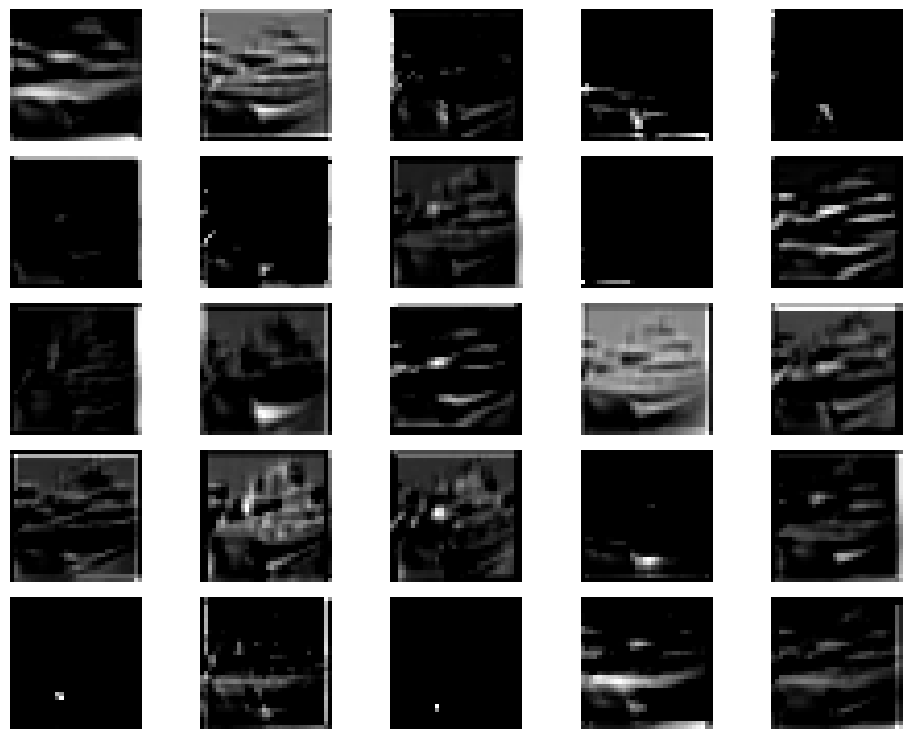

1/1 [==============================] - 0s 81ms/step


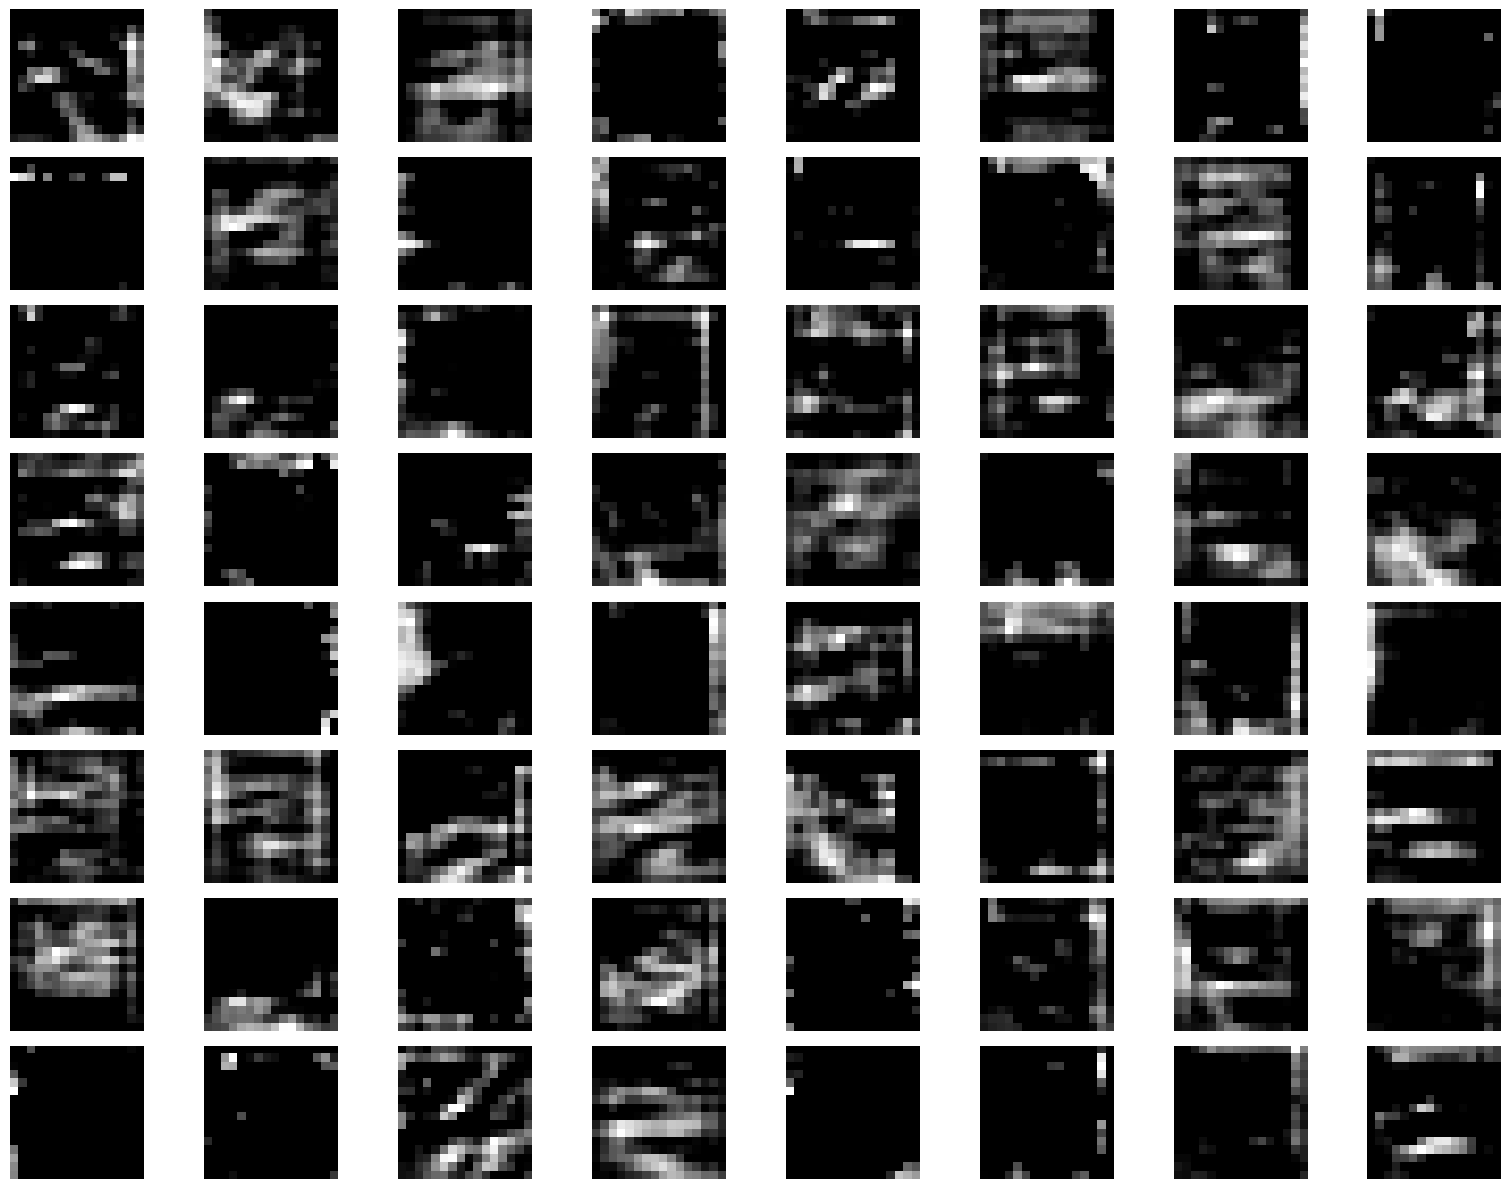

1/1 [==============================] - 0s 97ms/step


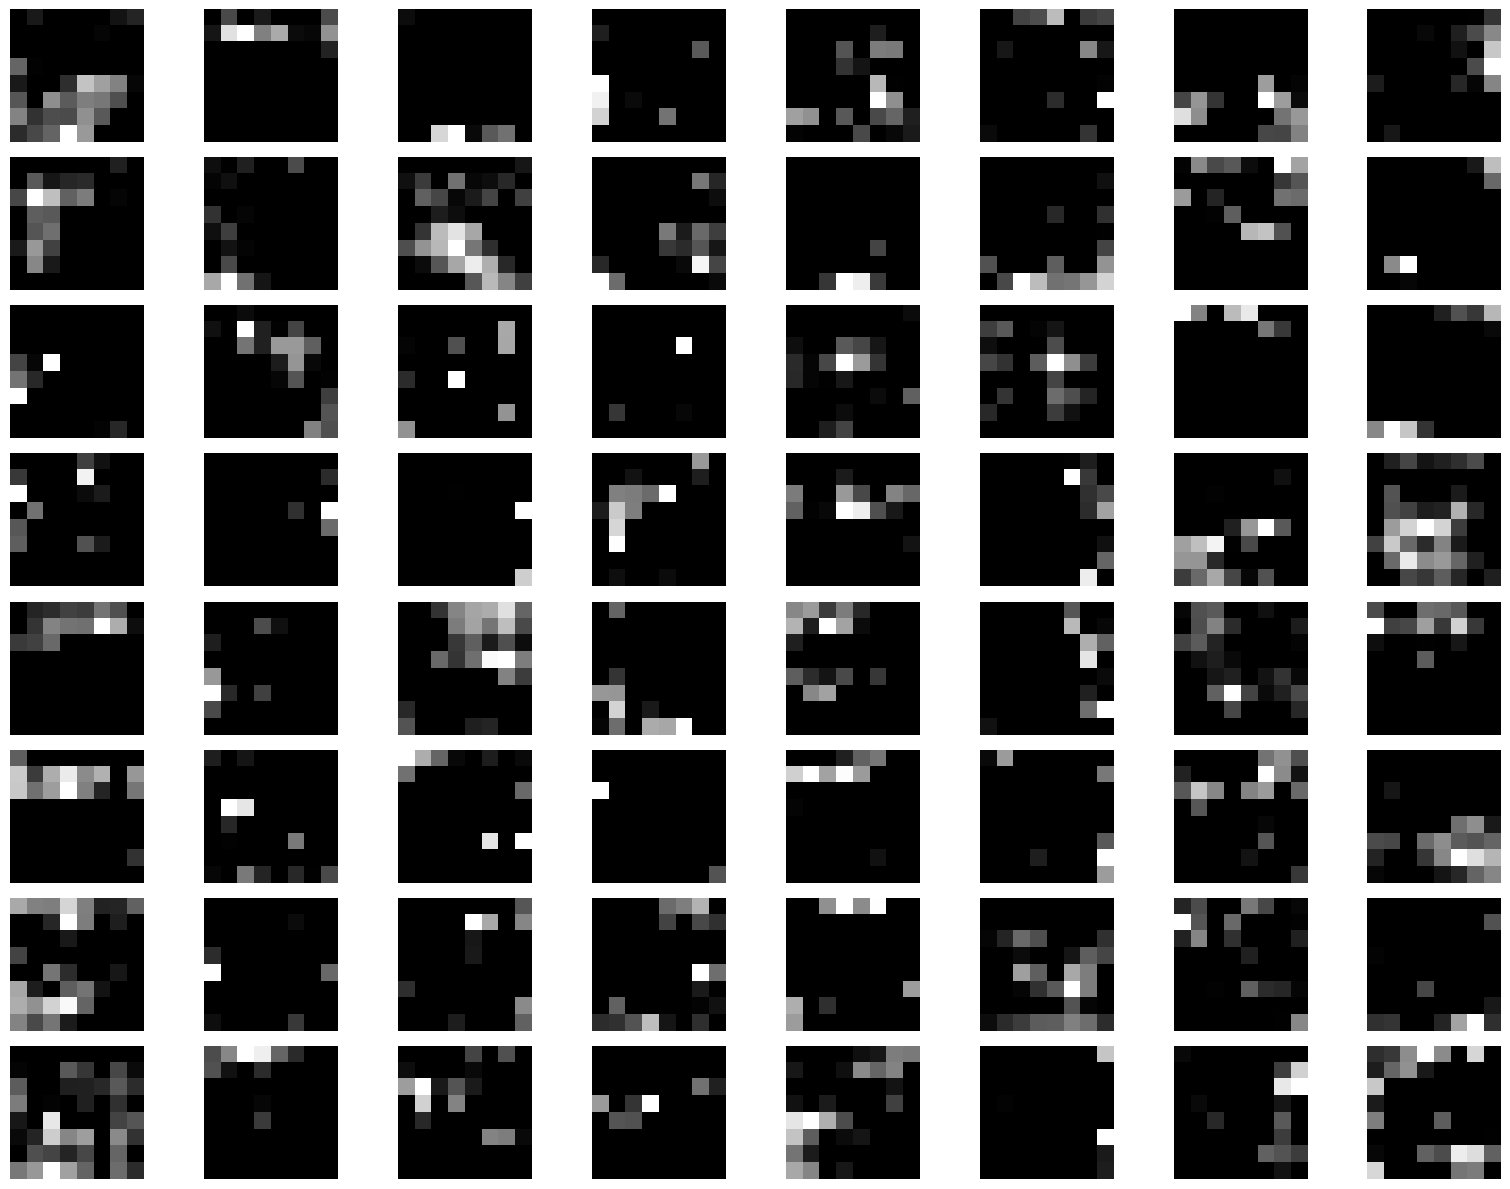

In [22]:
getmap(model_bigfilter,0)
getmap(model_bigfilter,4)
getmap(model_bigfilter,7)

### Attempt at staggering filter sizes

In [23]:
model_somewhatbigfilter = Sequential()
model_somewhatbigfilter.add(Conv2D(32, (7,7), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_somewhatbigfilter.add(Conv2D(32, (7,7), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_somewhatbigfilter.add(MaxPooling2D((2,2)))
model_somewhatbigfilter.add(Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_somewhatbigfilter.add(Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_somewhatbigfilter.add(MaxPooling2D((2,2)))
model_somewhatbigfilter.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_somewhatbigfilter.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_somewhatbigfilter.add(MaxPooling2D((2,2)))
model_somewhatbigfilter.add(Flatten())
model_somewhatbigfilter.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_somewhatbigfilter.add(Dense(10, activation='softmax'))
opt_somewhatbigfilter = SGD(learning_rate=0.001, momentum=0.9)
model_somewhatbigfilter.compile(optimizer=opt_somewhatbigfilter, loss='categorical_crossentropy', metrics=['accuracy'])
tc_somewhatbigfilter = TimeHistory()
model_somewhatbigfilter.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_somewhatbigfilter])
evaluate_model(model_somewhatbigfilter,tc_somewhatbigfilter)

Epoch 1/10
782/782 - 9s - loss: 1.7415 - accuracy: 0.3697 - val_loss: 1.4800 - val_accuracy: 0.4550 - 9s/epoch - 11ms/step
Epoch 2/10
782/782 - 7s - loss: 1.3898 - accuracy: 0.4993 - val_loss: 1.3088 - val_accuracy: 0.5292 - 7s/epoch - 9ms/step
Epoch 3/10
782/782 - 7s - loss: 1.2457 - accuracy: 0.5562 - val_loss: 1.2062 - val_accuracy: 0.5735 - 7s/epoch - 10ms/step
Epoch 4/10
782/782 - 7s - loss: 1.1393 - accuracy: 0.5969 - val_loss: 1.1230 - val_accuracy: 0.6013 - 7s/epoch - 9ms/step
Epoch 5/10
782/782 - 7s - loss: 1.0304 - accuracy: 0.6365 - val_loss: 1.0805 - val_accuracy: 0.6208 - 7s/epoch - 9ms/step
Epoch 6/10
782/782 - 7s - loss: 0.9491 - accuracy: 0.6662 - val_loss: 1.0198 - val_accuracy: 0.6437 - 7s/epoch - 9ms/step
Epoch 7/10
782/782 - 7s - loss: 0.8765 - accuracy: 0.6923 - val_loss: 0.9941 - val_accuracy: 0.6521 - 7s/epoch - 9ms/step
Epoch 8/10
782/782 - 7s - loss: 0.8129 - accuracy: 0.7162 - val_loss: 0.9659 - val_accuracy: 0.6612 - 7s/epoch - 9ms/step
Epoch 9/10
782/782 - 7

1/1 [==============================] - 0s 43ms/step


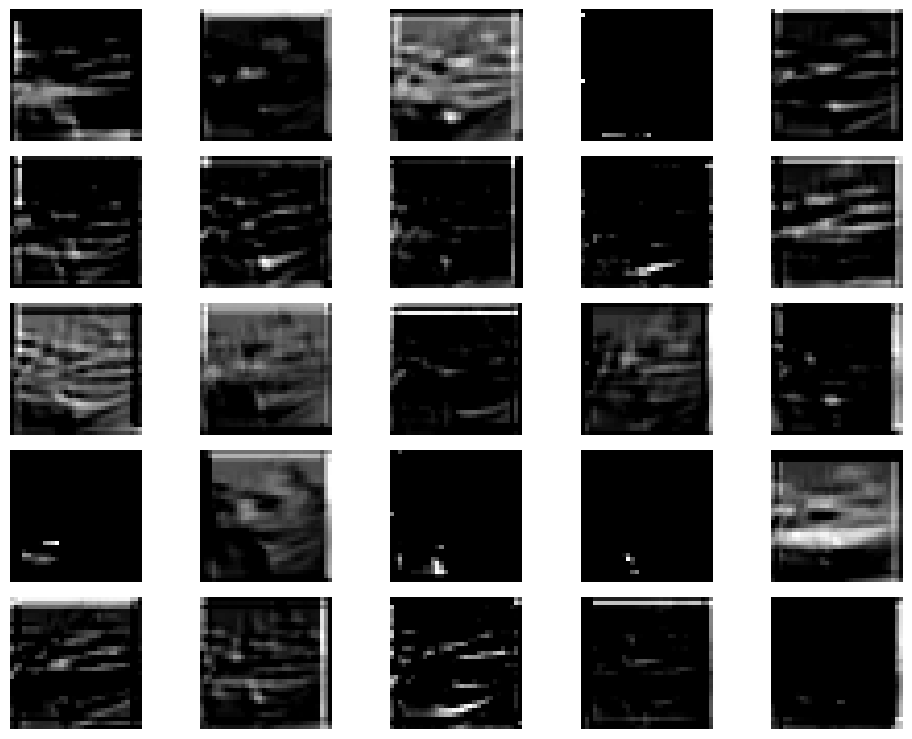

1/1 [==============================] - 0s 70ms/step


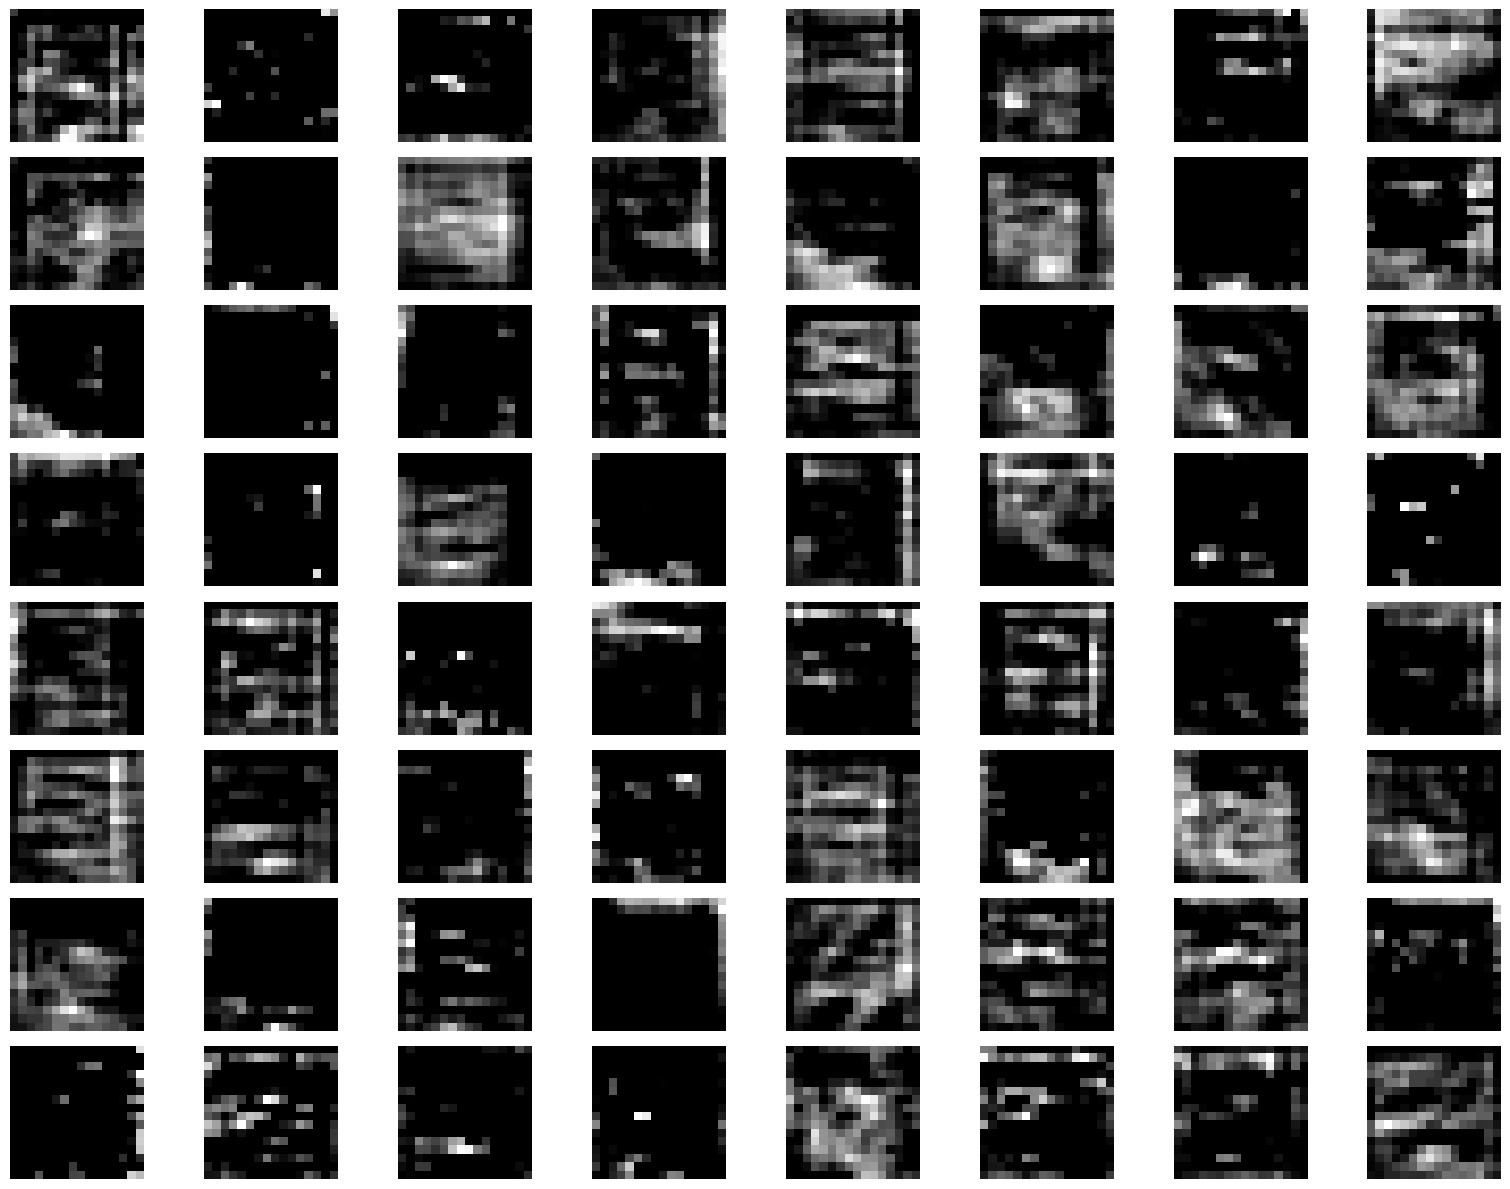

1/1 [==============================] - 0s 92ms/step


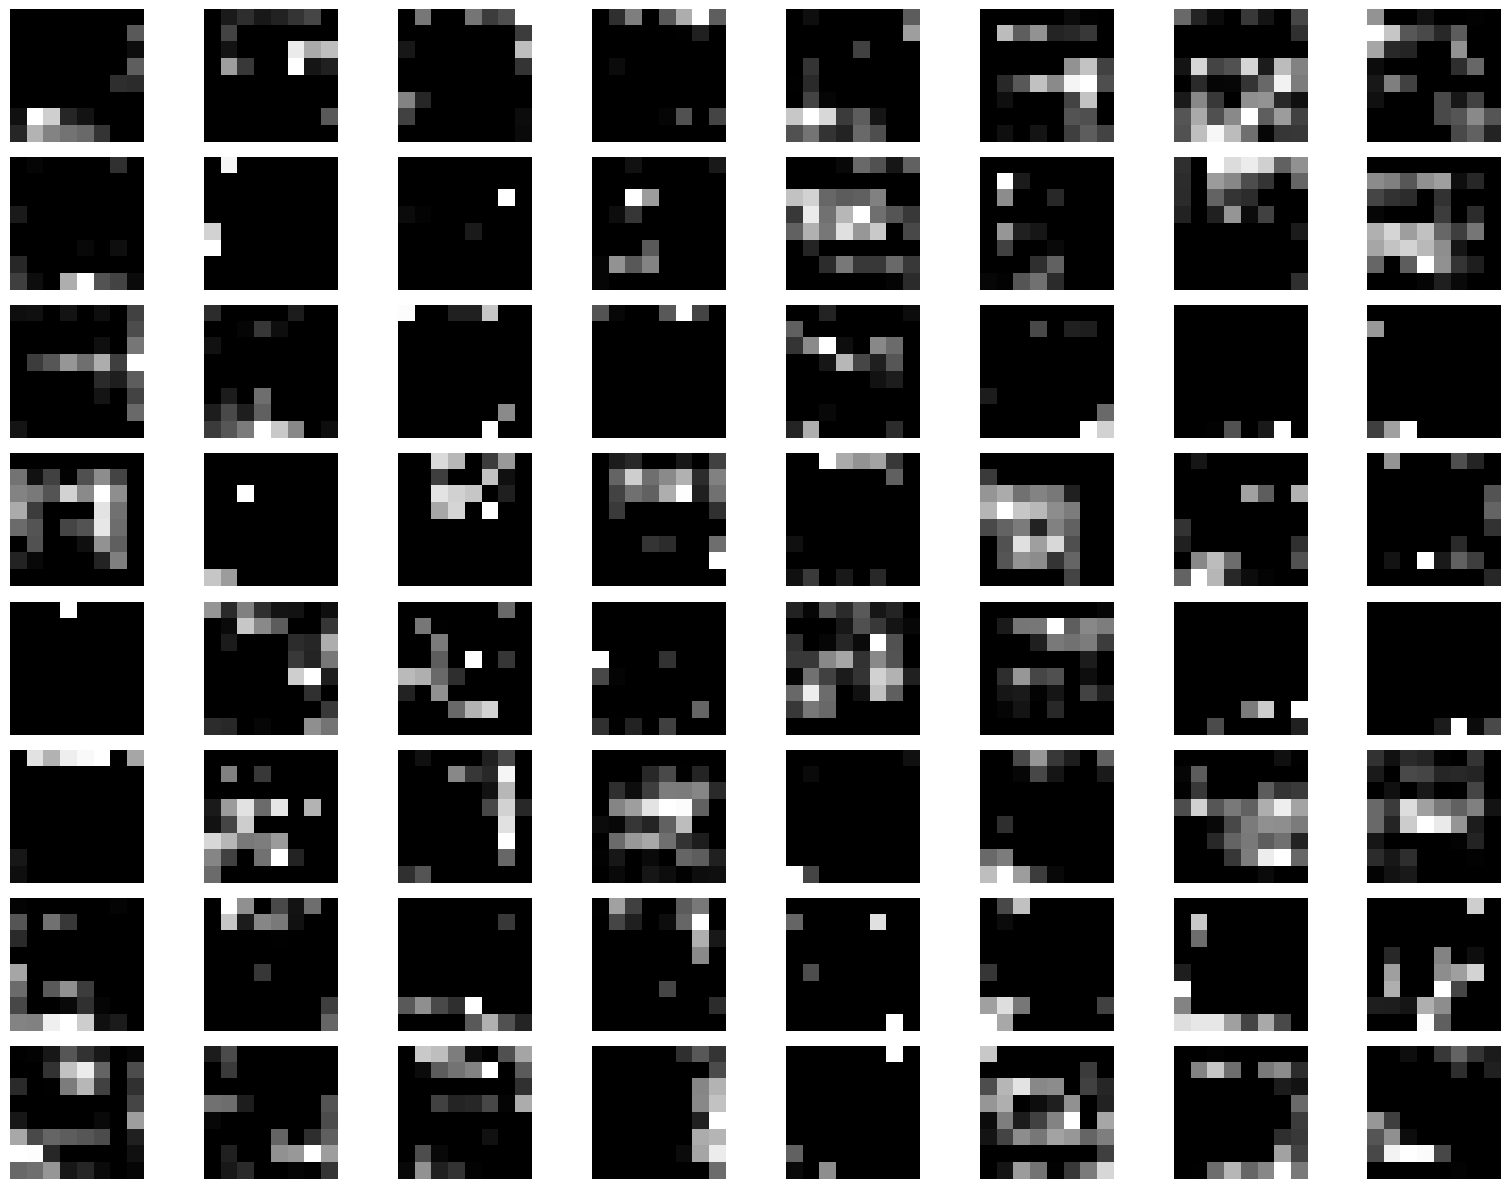

In [24]:
getmap(model_somewhatbigfilter,0)
getmap(model_somewhatbigfilter,4)
getmap(model_somewhatbigfilter,7)

# Q3-C


### Very high dropout value

In [26]:
model_noobdropout = Sequential()
model_noobdropout.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_noobdropout.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_noobdropout.add(MaxPooling2D((2,2)))
model_noobdropout.add(Dropout(0.4))
model_noobdropout.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_noobdropout.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_noobdropout.add(MaxPooling2D((2,2)))
model_noobdropout.add(Dropout(0.4))
model_noobdropout.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_noobdropout.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_noobdropout.add(MaxPooling2D((2,2)))
model_noobdropout.add(Dropout(0.4))
model_noobdropout.add(Flatten())
model_noobdropout.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_noobdropout.add(Dropout(0.4))
model_noobdropout.add(Dense(10, activation='softmax'))
opt_noobdropout = SGD(learning_rate=0.001, momentum=0.9)
model_noobdropout.compile(optimizer=opt_noobdropout, loss='categorical_crossentropy', metrics=['accuracy'])
tc_noobdropout = TimeHistory()
model_noobdropout.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_noobdropout])
evaluate_model(model_noobdropout,tc_noobdropout)

Epoch 1/10


2023-02-26 10:10:18.418554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 - 7s - loss: 2.1777 - accuracy: 0.1740 - val_loss: 2.0019 - val_accuracy: 0.2742 - 7s/epoch - 9ms/step
Epoch 2/10
782/782 - 6s - loss: 1.9400 - accuracy: 0.2589 - val_loss: 1.8317 - val_accuracy: 0.3339 - 6s/epoch - 7ms/step
Epoch 3/10
782/782 - 5s - loss: 1.8018 - accuracy: 0.3138 - val_loss: 1.6974 - val_accuracy: 0.3700 - 5s/epoch - 7ms/step
Epoch 4/10
782/782 - 6s - loss: 1.7041 - accuracy: 0.3566 - val_loss: 1.6220 - val_accuracy: 0.4072 - 6s/epoch - 7ms/step
Epoch 5/10
782/782 - 5s - loss: 1.6339 - accuracy: 0.3856 - val_loss: 1.5809 - val_accuracy: 0.4151 - 5s/epoch - 7ms/step
Epoch 6/10
782/782 - 6s - loss: 1.5777 - accuracy: 0.4107 - val_loss: 1.4821 - val_accuracy: 0.4538 - 6s/epoch - 7ms/step
Epoch 7/10
782/782 - 5s - loss: 1.5227 - accuracy: 0.4365 - val_loss: 1.4627 - val_accuracy: 0.4638 - 5s/epoch - 7ms/step
Epoch 8/10
782/782 - 6s - loss: 1.4794 - accuracy: 0.4542 - val_loss: 1.3942 - val_accuracy: 0.4993 - 6s/epoch - 7ms/step
Epoch 9/10
782/782 - 5s - loss: 1.4

### Decently low dropout value + 15 epochs <- Reason mentioned in report

In [27]:
model_dropout = Sequential()
model_dropout.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_dropout.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(MaxPooling2D((2,2)))
model_dropout.add(Dropout(0.1))
model_dropout.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(MaxPooling2D((2,2)))
model_dropout.add(Dropout(0.1))
model_dropout.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_dropout.add(MaxPooling2D((2,2)))
model_dropout.add(Dropout(0.1))
model_dropout.add(Flatten())
model_dropout.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_dropout.add(Dropout(0.1))
model_dropout.add(Dense(10, activation='softmax'))
opt_dropout = SGD(learning_rate=0.001, momentum=0.9)
model_dropout.compile(optimizer=opt_dropout, loss='categorical_crossentropy', metrics=['accuracy'])
tc_dropout = TimeHistory()
model_dropout.fit(trainX, trainY, epochs=15, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_dropout])
evaluate_model(model_dropout,tc_dropout)

Epoch 1/15


2023-02-26 10:12:47.580965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 - 7s - loss: 1.8945 - accuracy: 0.2966 - val_loss: 1.6033 - val_accuracy: 0.4099 - 7s/epoch - 9ms/step
Epoch 2/15
782/782 - 5s - loss: 1.5682 - accuracy: 0.4246 - val_loss: 1.4704 - val_accuracy: 0.4703 - 5s/epoch - 7ms/step
Epoch 3/15
782/782 - 6s - loss: 1.4198 - accuracy: 0.4822 - val_loss: 1.3257 - val_accuracy: 0.5317 - 6s/epoch - 7ms/step
Epoch 4/15
782/782 - 6s - loss: 1.3078 - accuracy: 0.5282 - val_loss: 1.2274 - val_accuracy: 0.5648 - 6s/epoch - 7ms/step
Epoch 5/15
782/782 - 6s - loss: 1.2106 - accuracy: 0.5677 - val_loss: 1.1094 - val_accuracy: 0.6089 - 6s/epoch - 7ms/step
Epoch 6/15
782/782 - 6s - loss: 1.1378 - accuracy: 0.5949 - val_loss: 1.0967 - val_accuracy: 0.6027 - 6s/epoch - 7ms/step
Epoch 7/15
782/782 - 6s - loss: 1.0627 - accuracy: 0.6210 - val_loss: 0.9926 - val_accuracy: 0.6451 - 6s/epoch - 7ms/step
Epoch 8/15
782/782 - 6s - loss: 1.0079 - accuracy: 0.6436 - val_loss: 0.9687 - val_accuracy: 0.6573 - 6s/epoch - 7ms/step
Epoch 9/15
782/782 - 5s - loss: 0.9

1/1 [==============================] - 0s 41ms/step


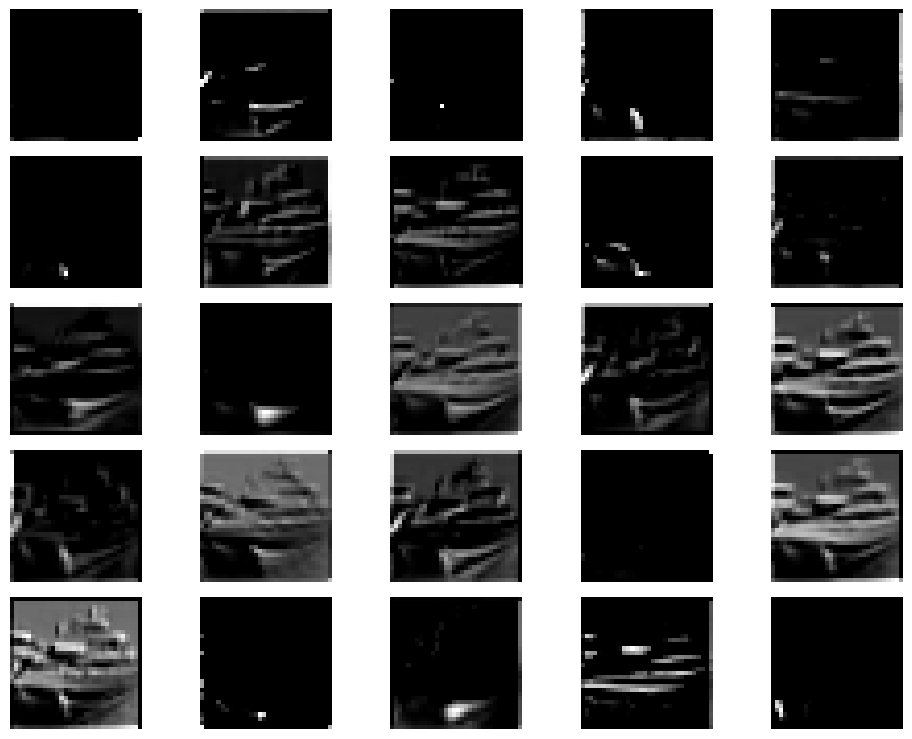

1/1 [==============================] - 0s 66ms/step


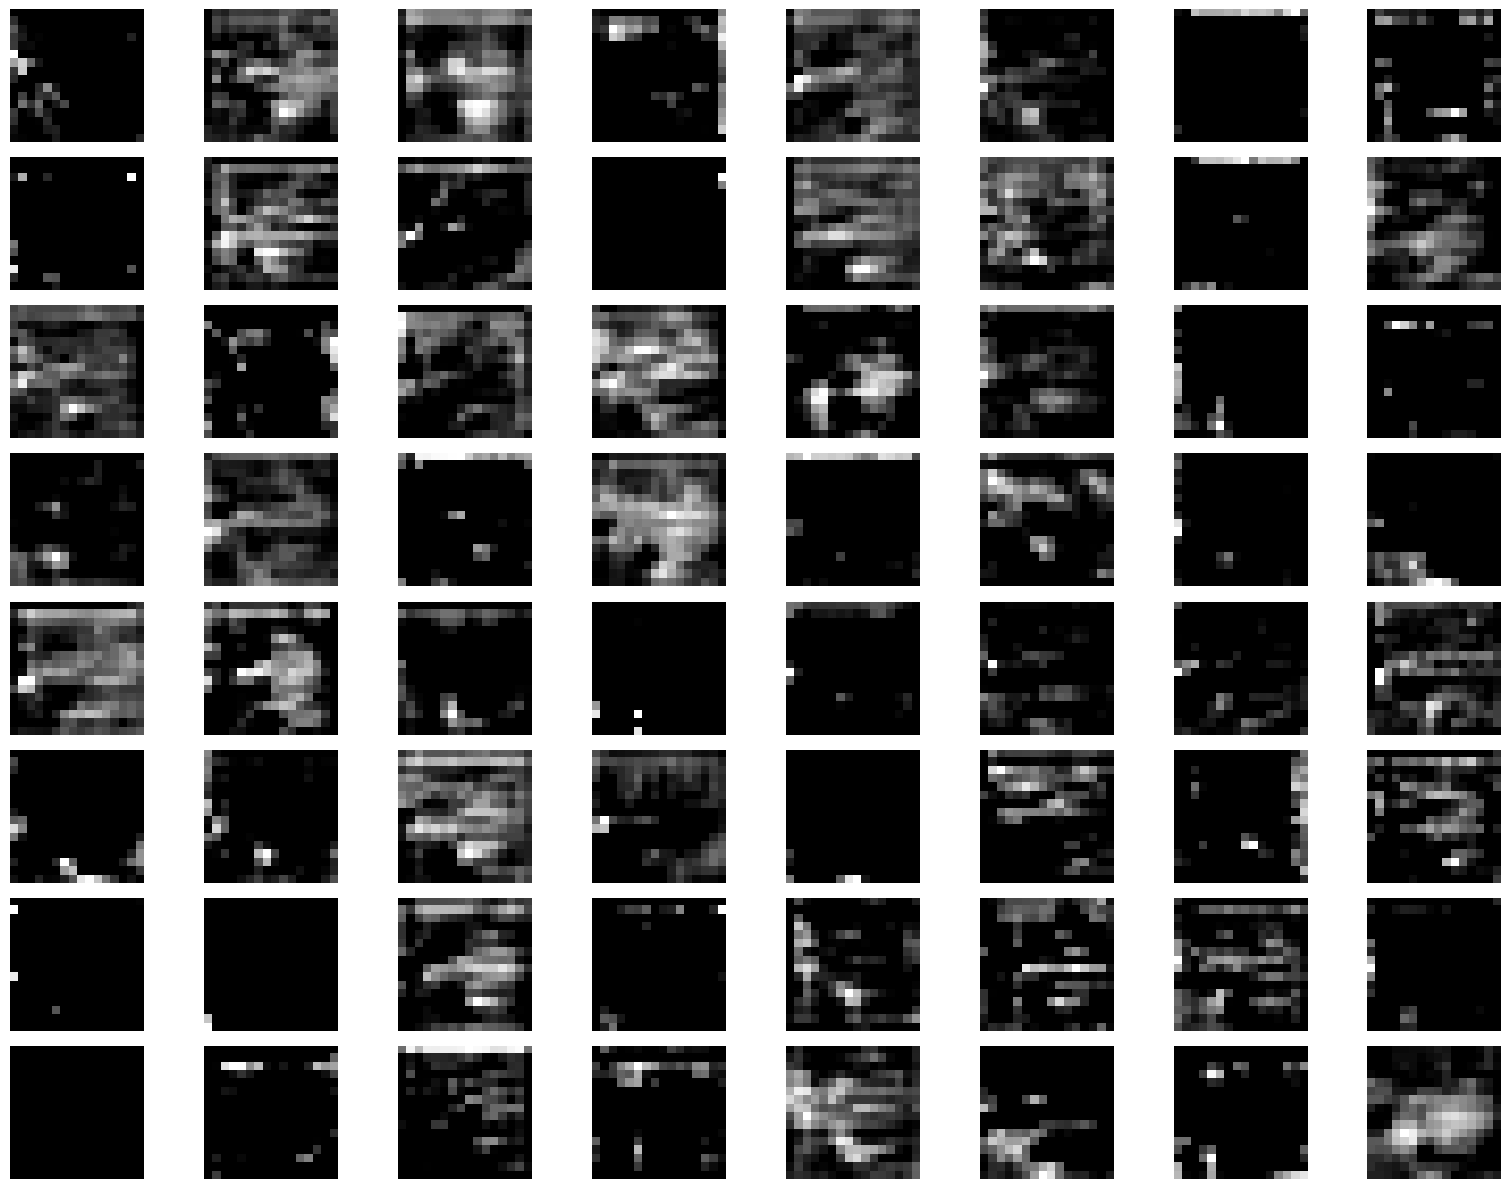

1/1 [==============================] - 0s 94ms/step


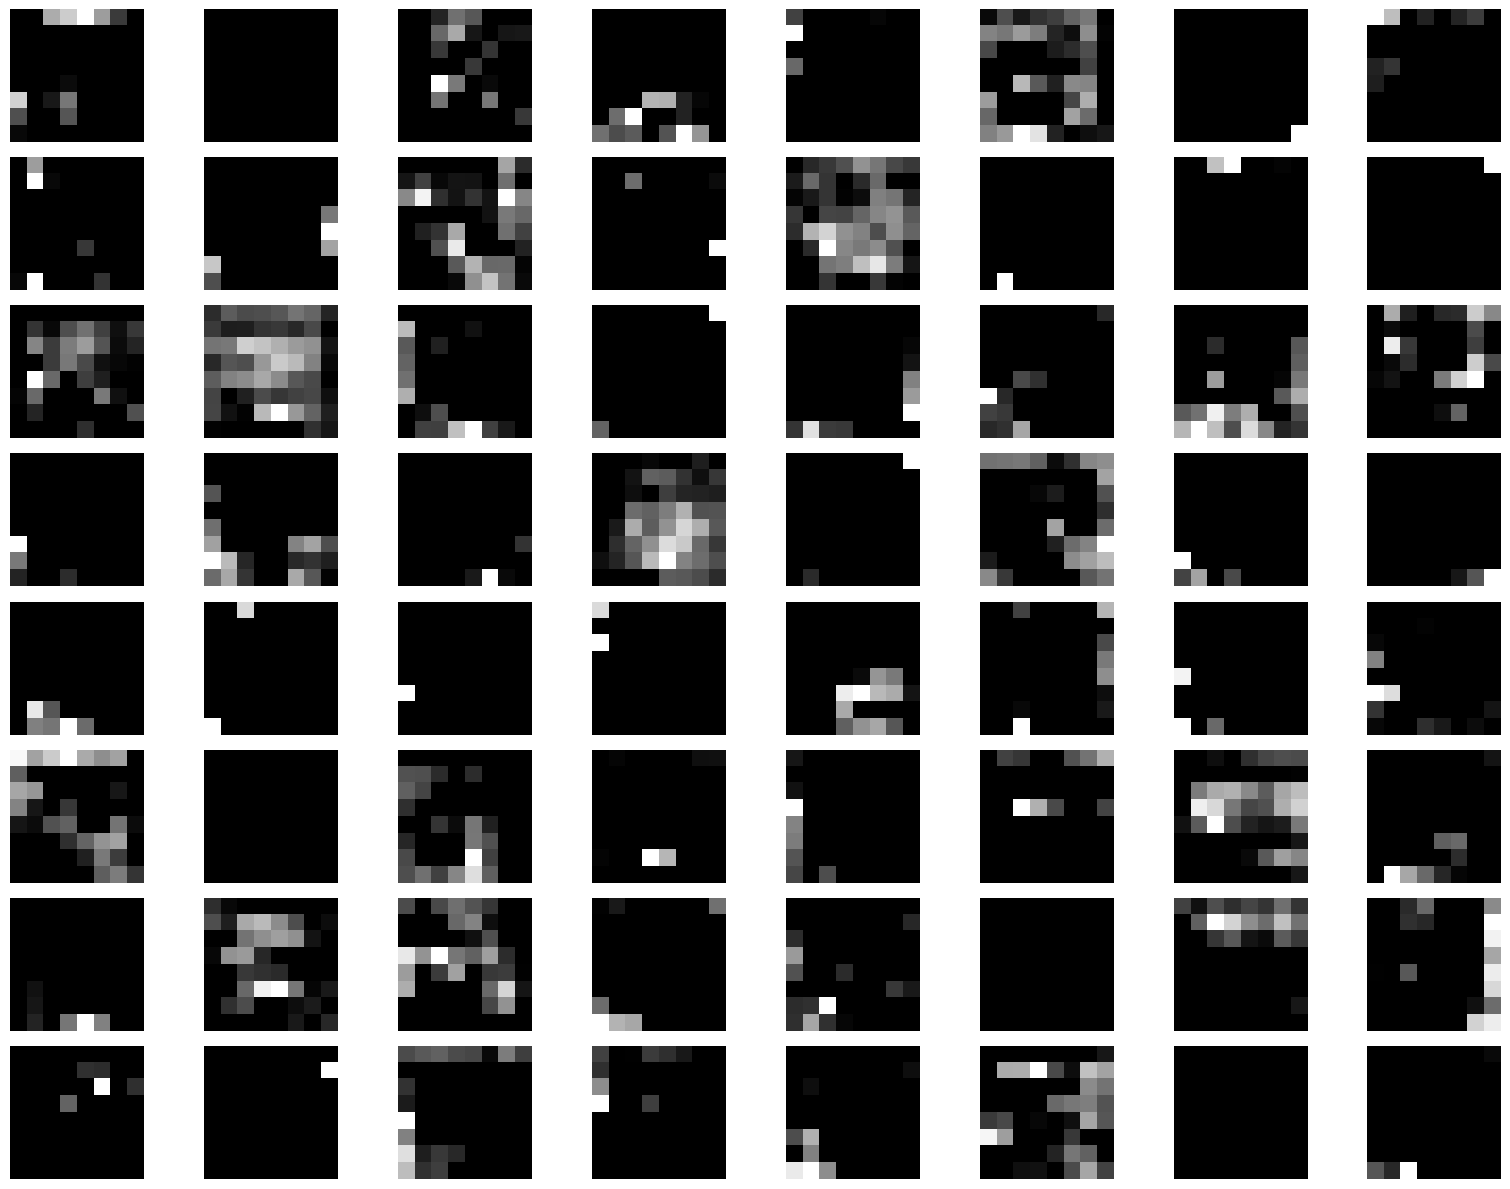

In [28]:
getmap(model_dropout,0)
getmap(model_dropout,5)
getmap(model_dropout,9)

# Q3-D

### Initial and final layers for base model

1/1 [==============================] - 0s 45ms/step


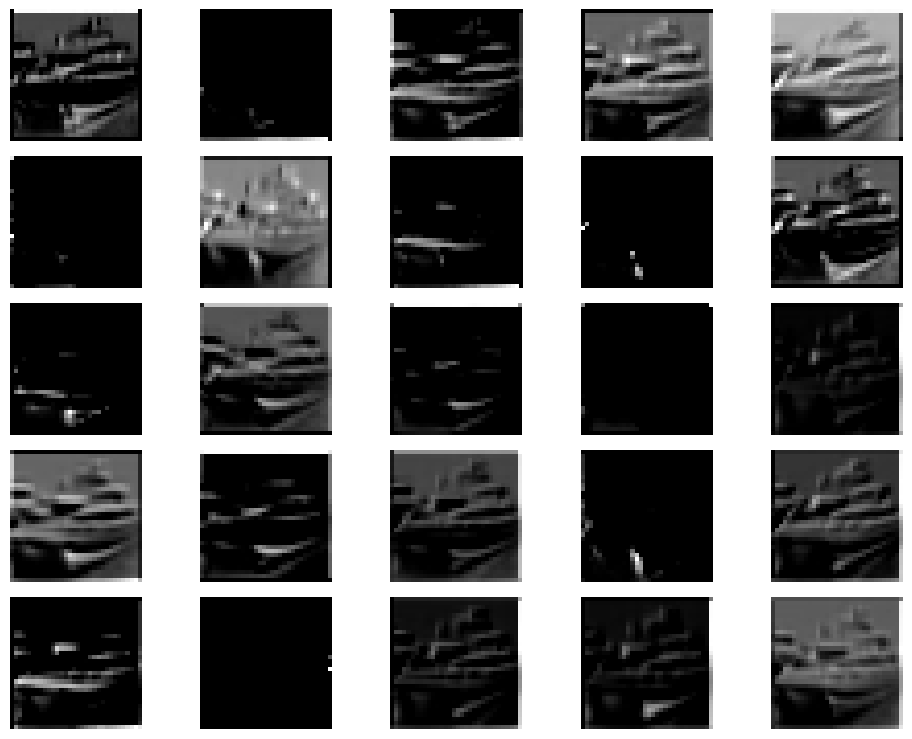

1/1 [==============================] - 0s 85ms/step


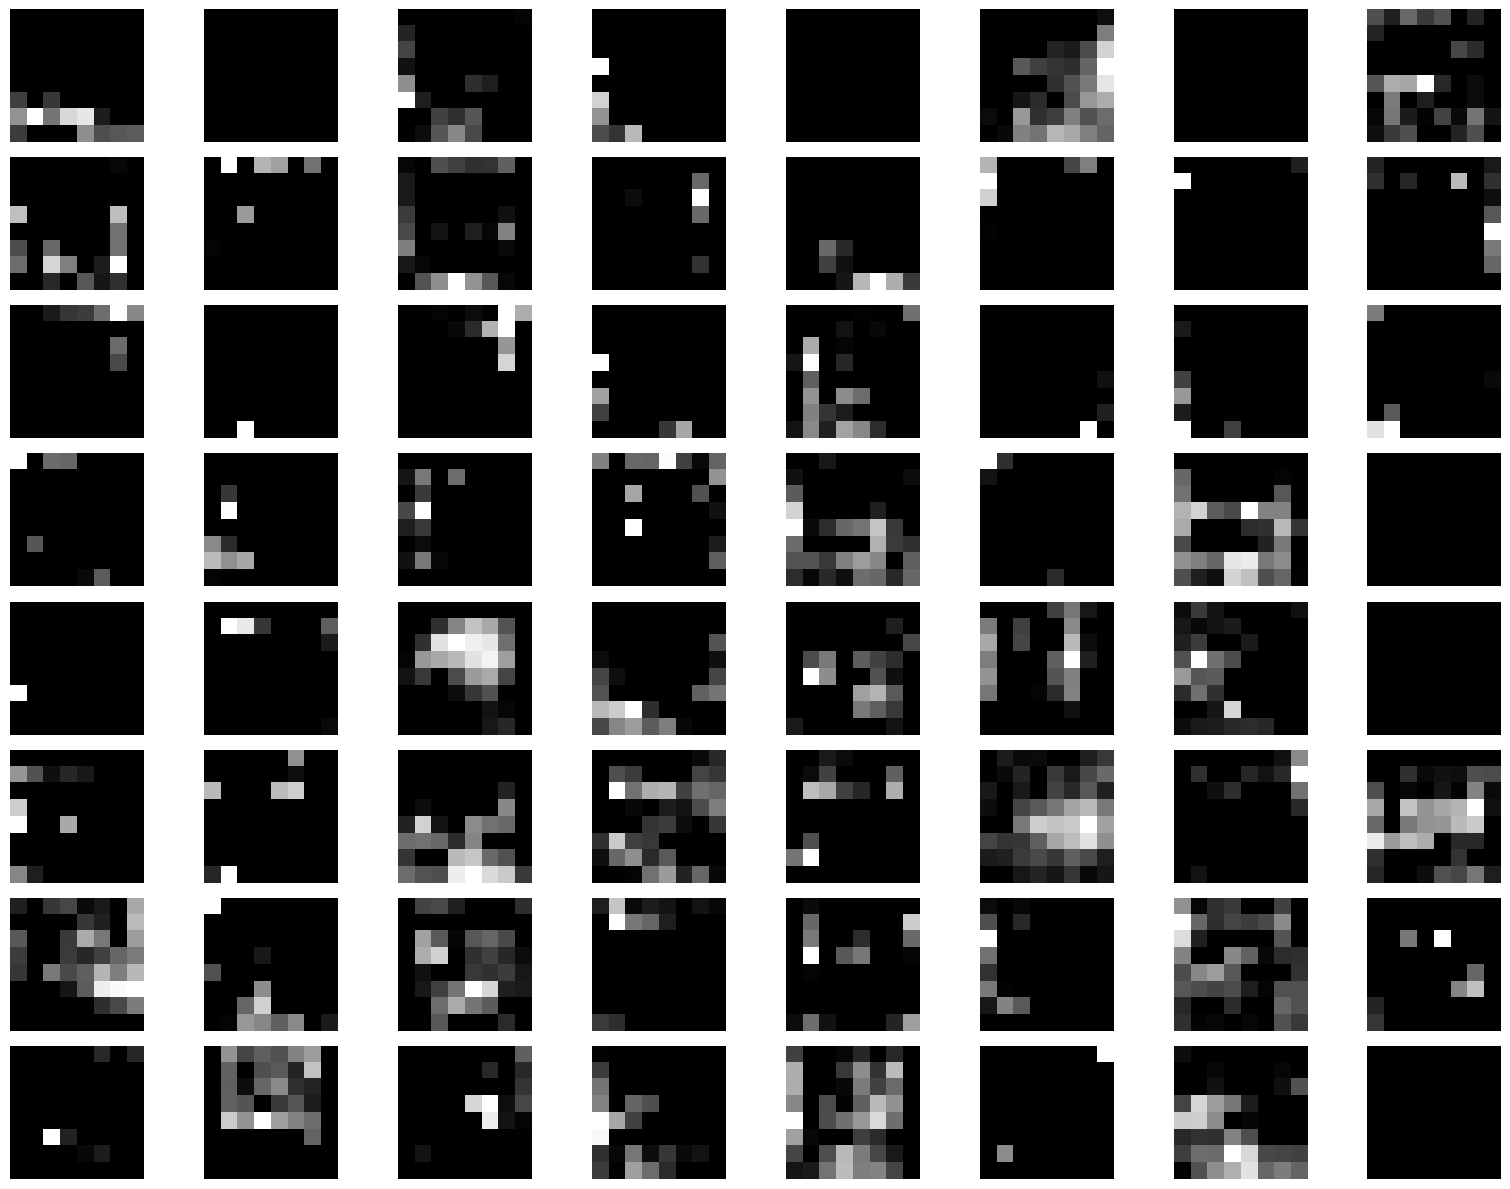

In [29]:
getmap(model_base,0)
getmap(model_base,7)

### Initial + final layers for the best model I have till now

1/1 [==============================] - 0s 71ms/step


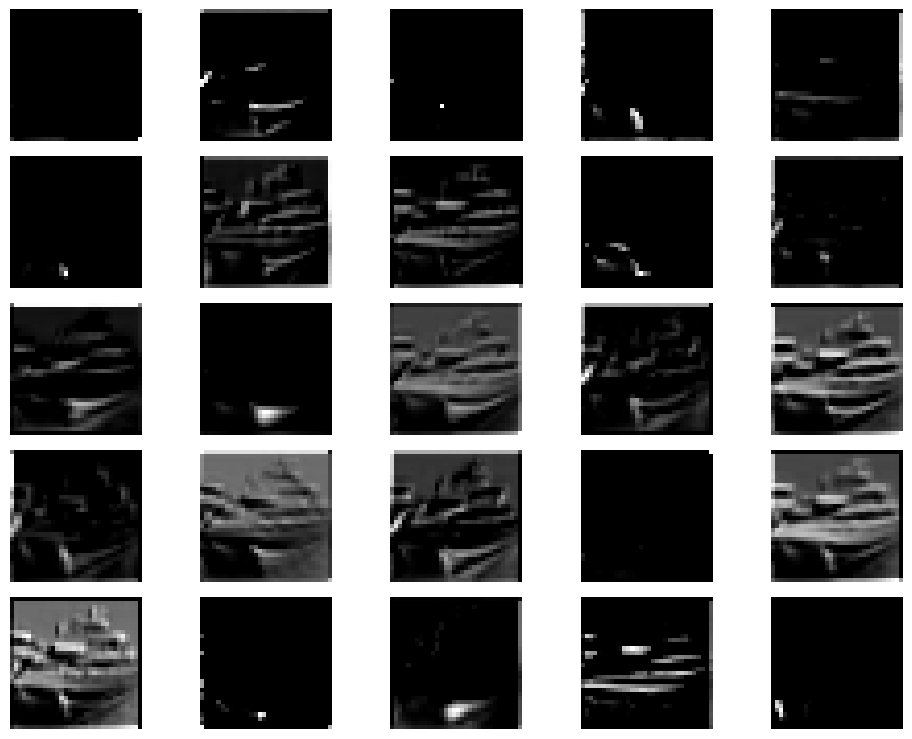

1/1 [==============================] - 0s 87ms/step


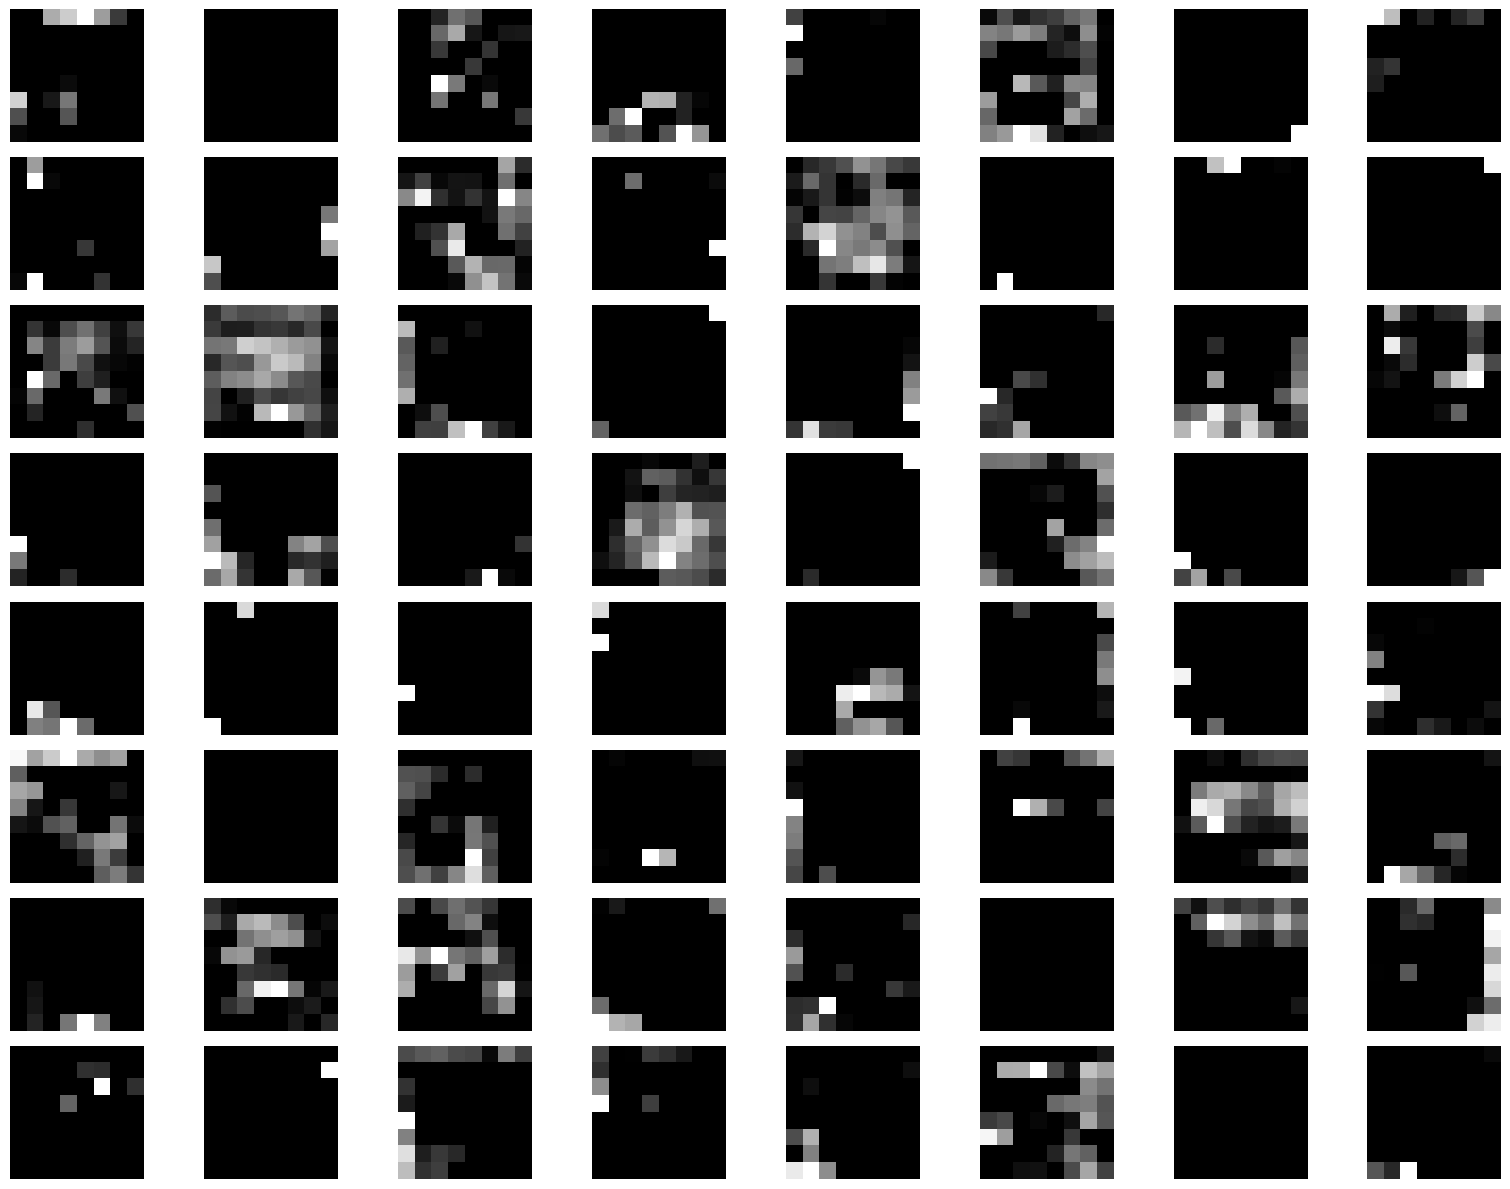

In [38]:
getmap(model_dropout,0)
getmap(model_dropout,9)

# Q3-E


Class [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 50ms/step


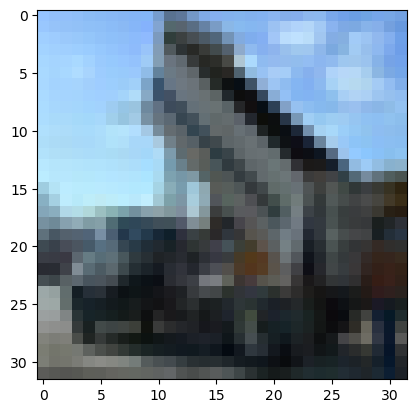

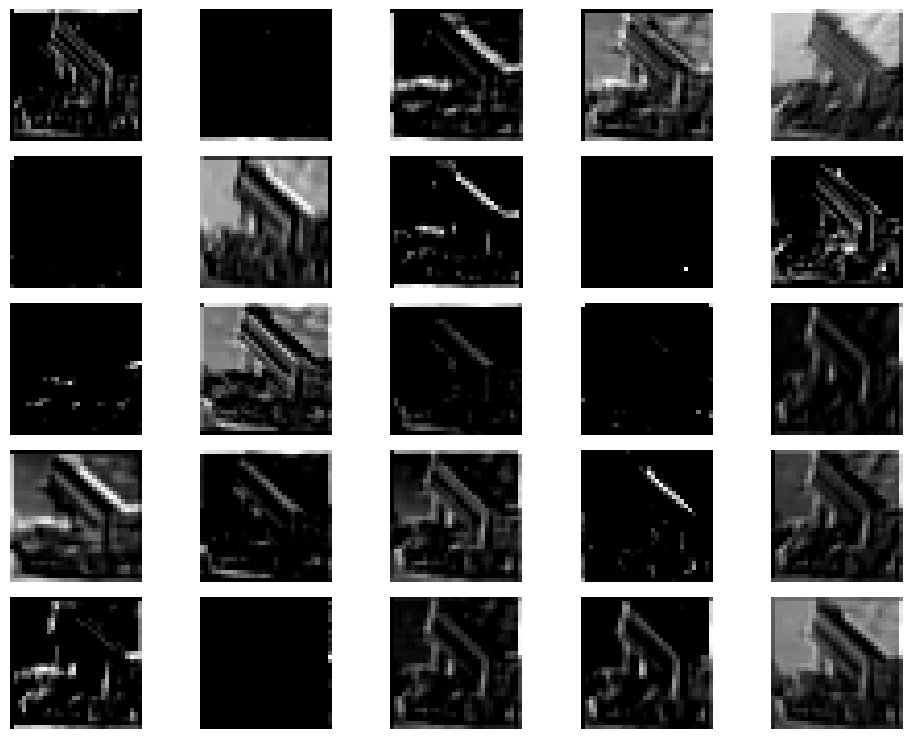

1/1 [==============================] - 0s 95ms/step


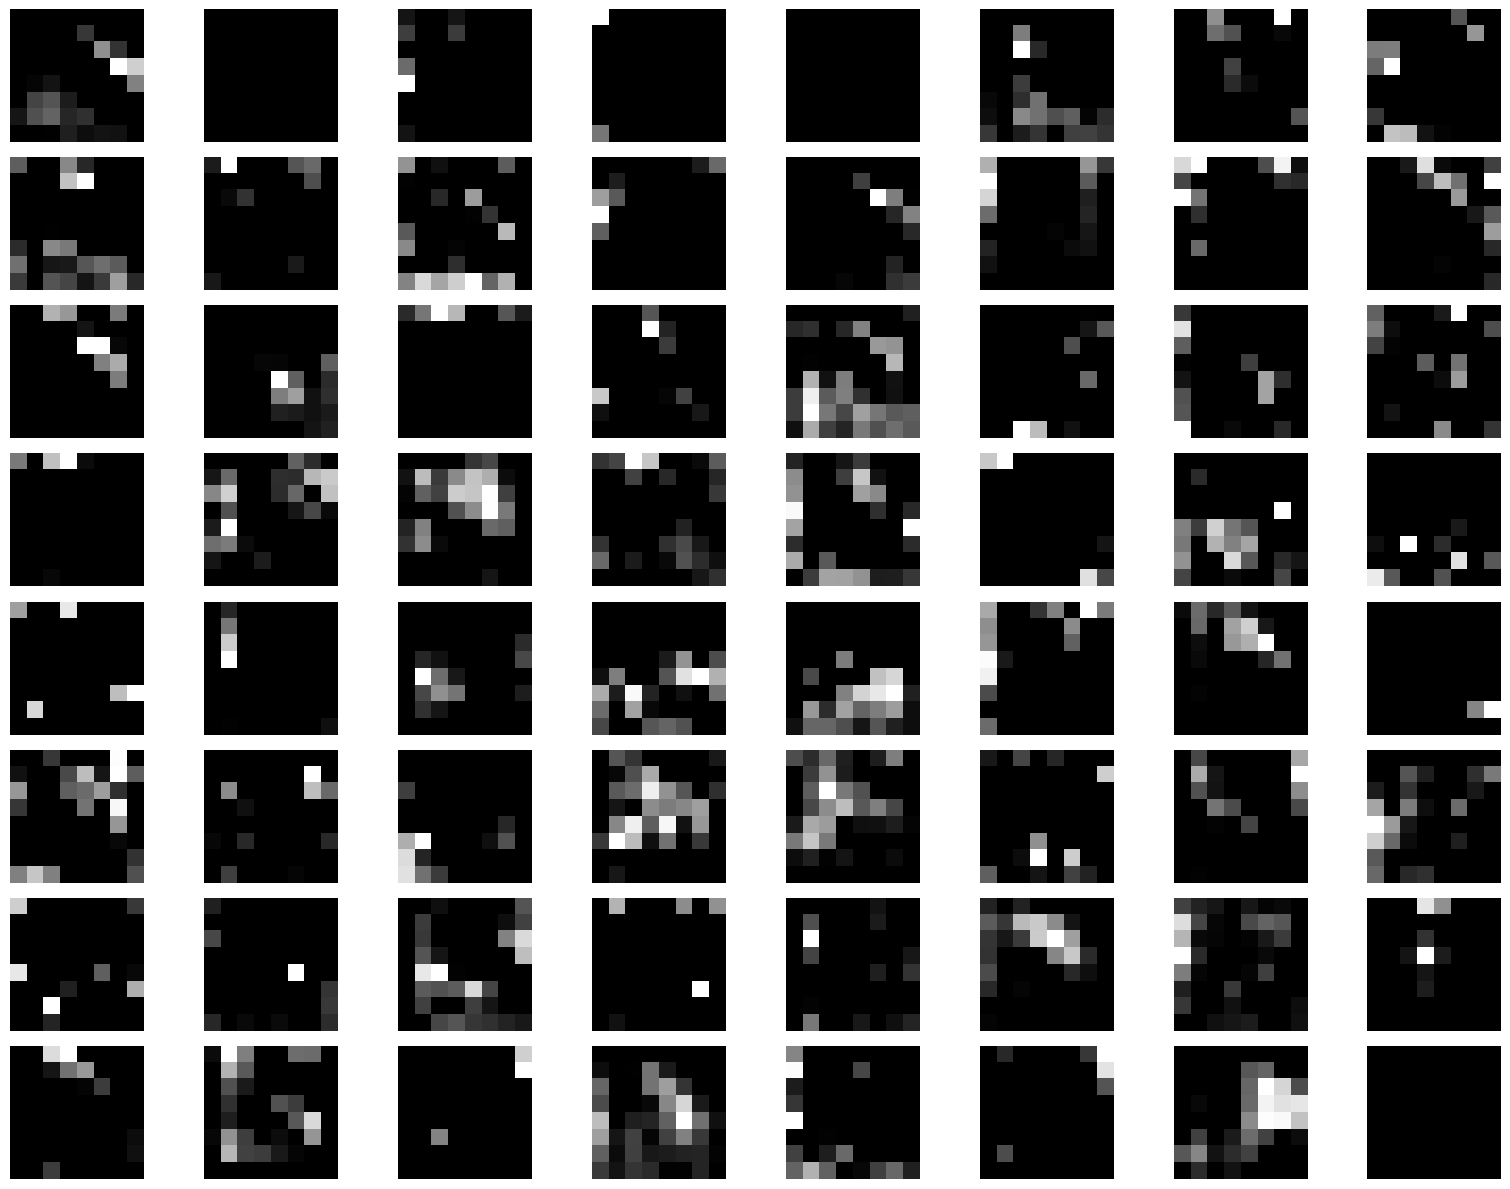

In [31]:
plt.imshow(testX[50])
print("Class",testY[50])
getmap(model_base,0, 50)
getmap(model_base,7, 50)

Class [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 47ms/step


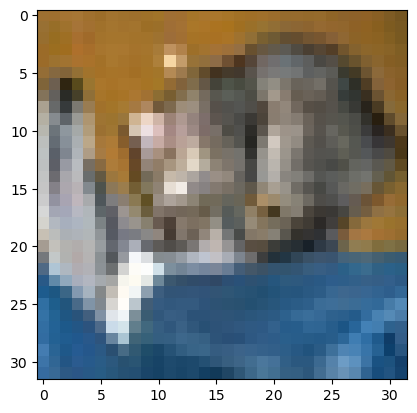

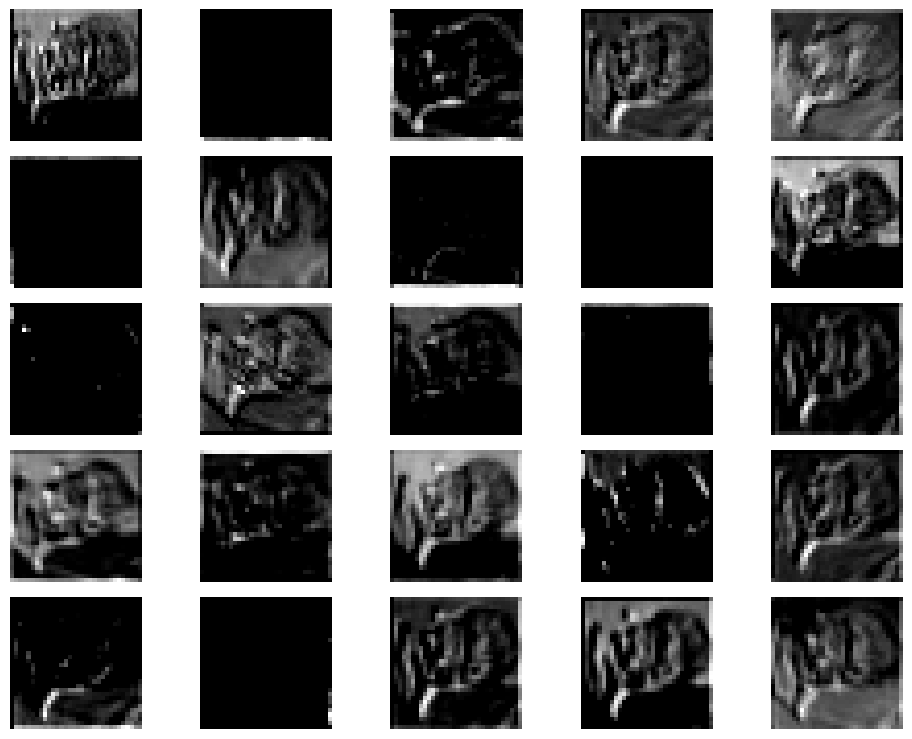

1/1 [==============================] - 0s 82ms/step


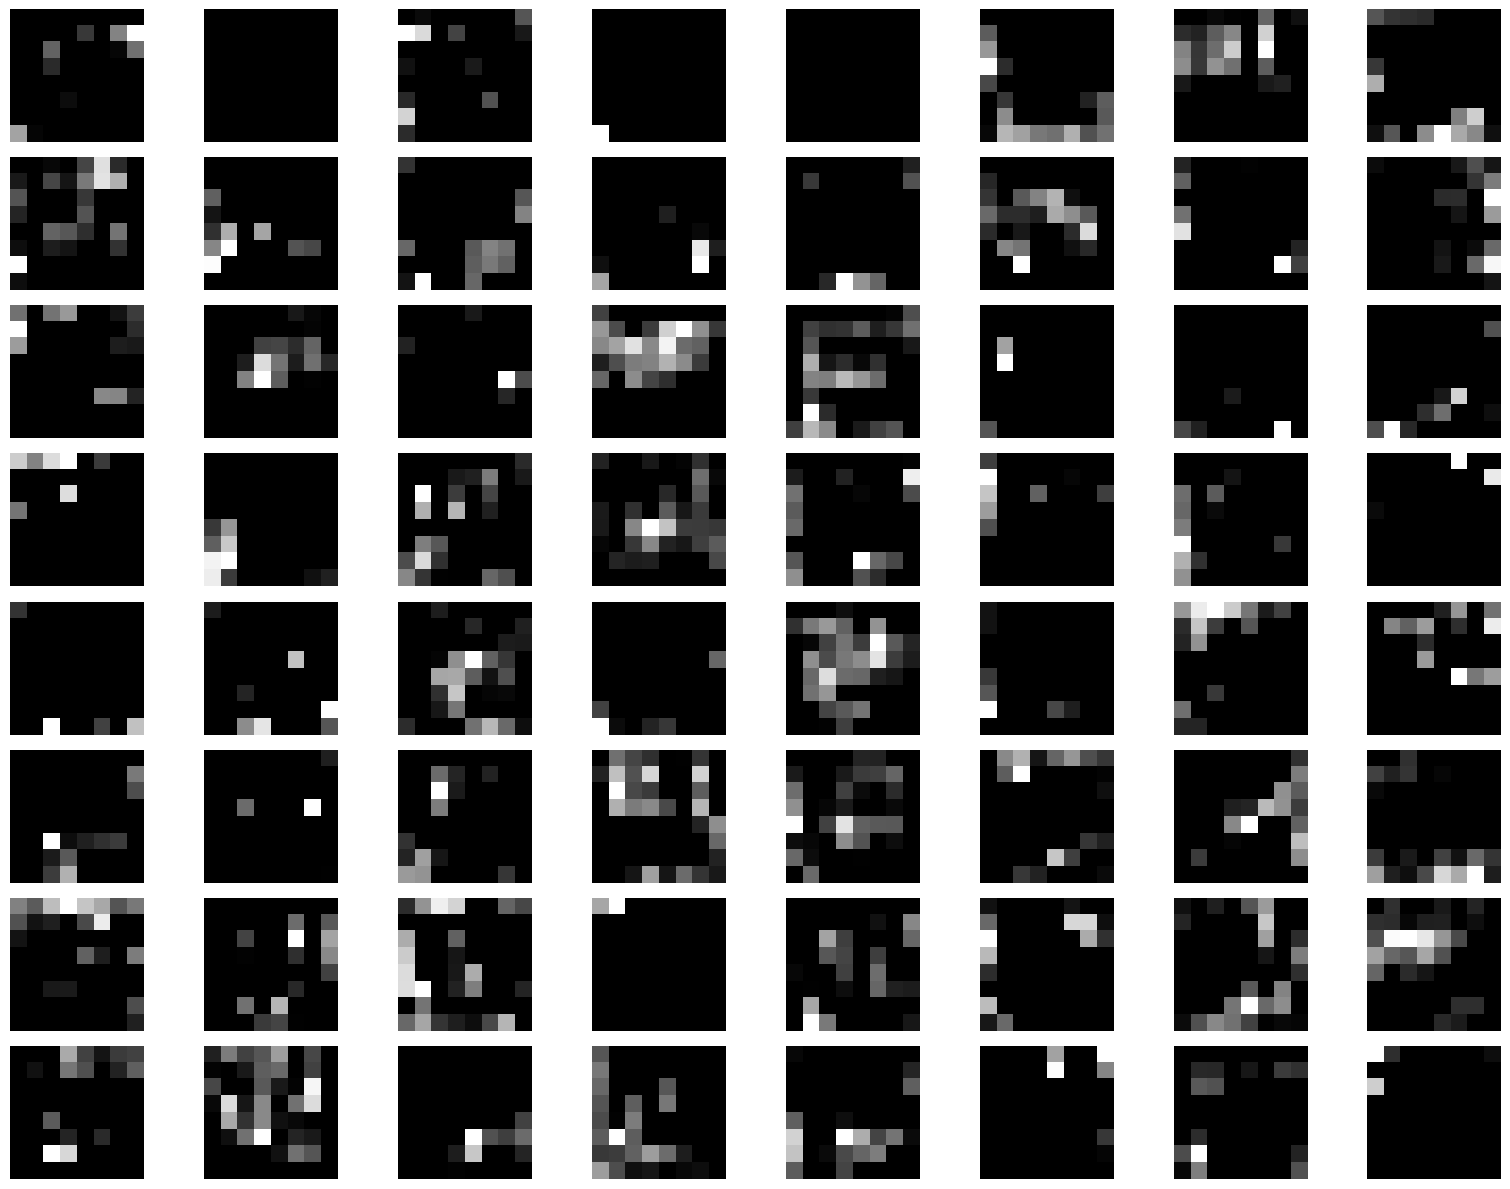

In [33]:
plt.imshow(testX[0])
print("Class",testY[0])
getmap(model_base,0, 0)
getmap(model_base,7, 0)

Class [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1/1 [==============================] - 0s 51ms/step


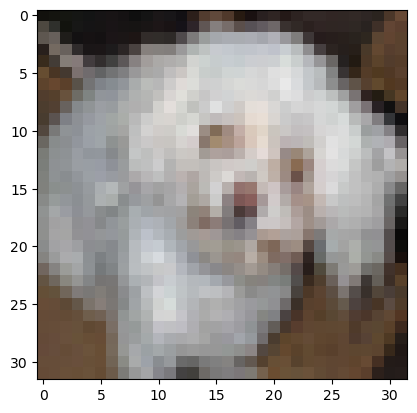

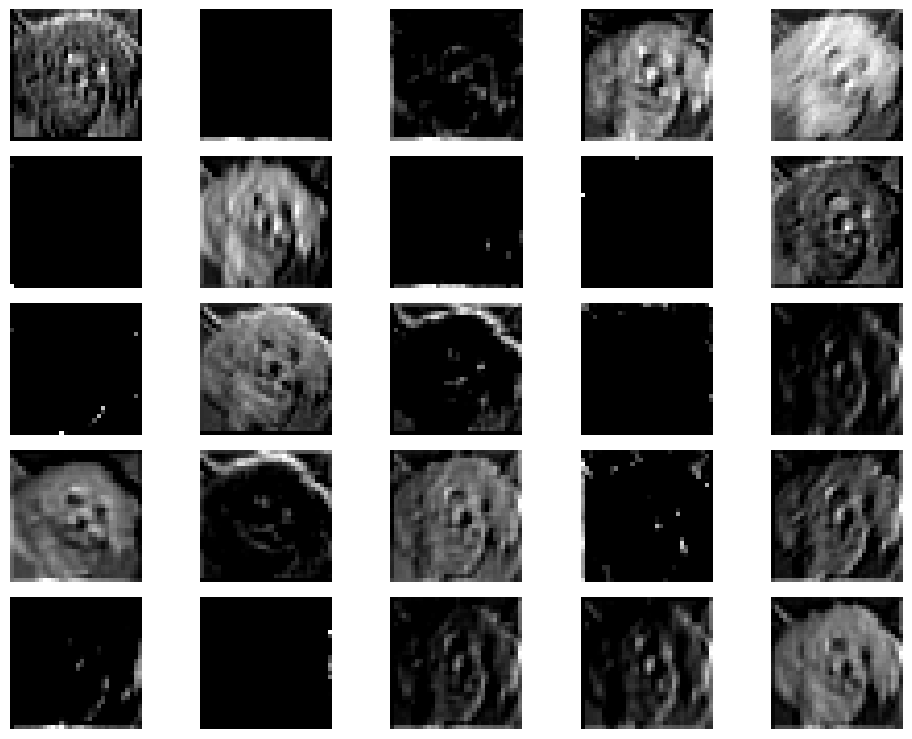

1/1 [==============================] - 0s 80ms/step


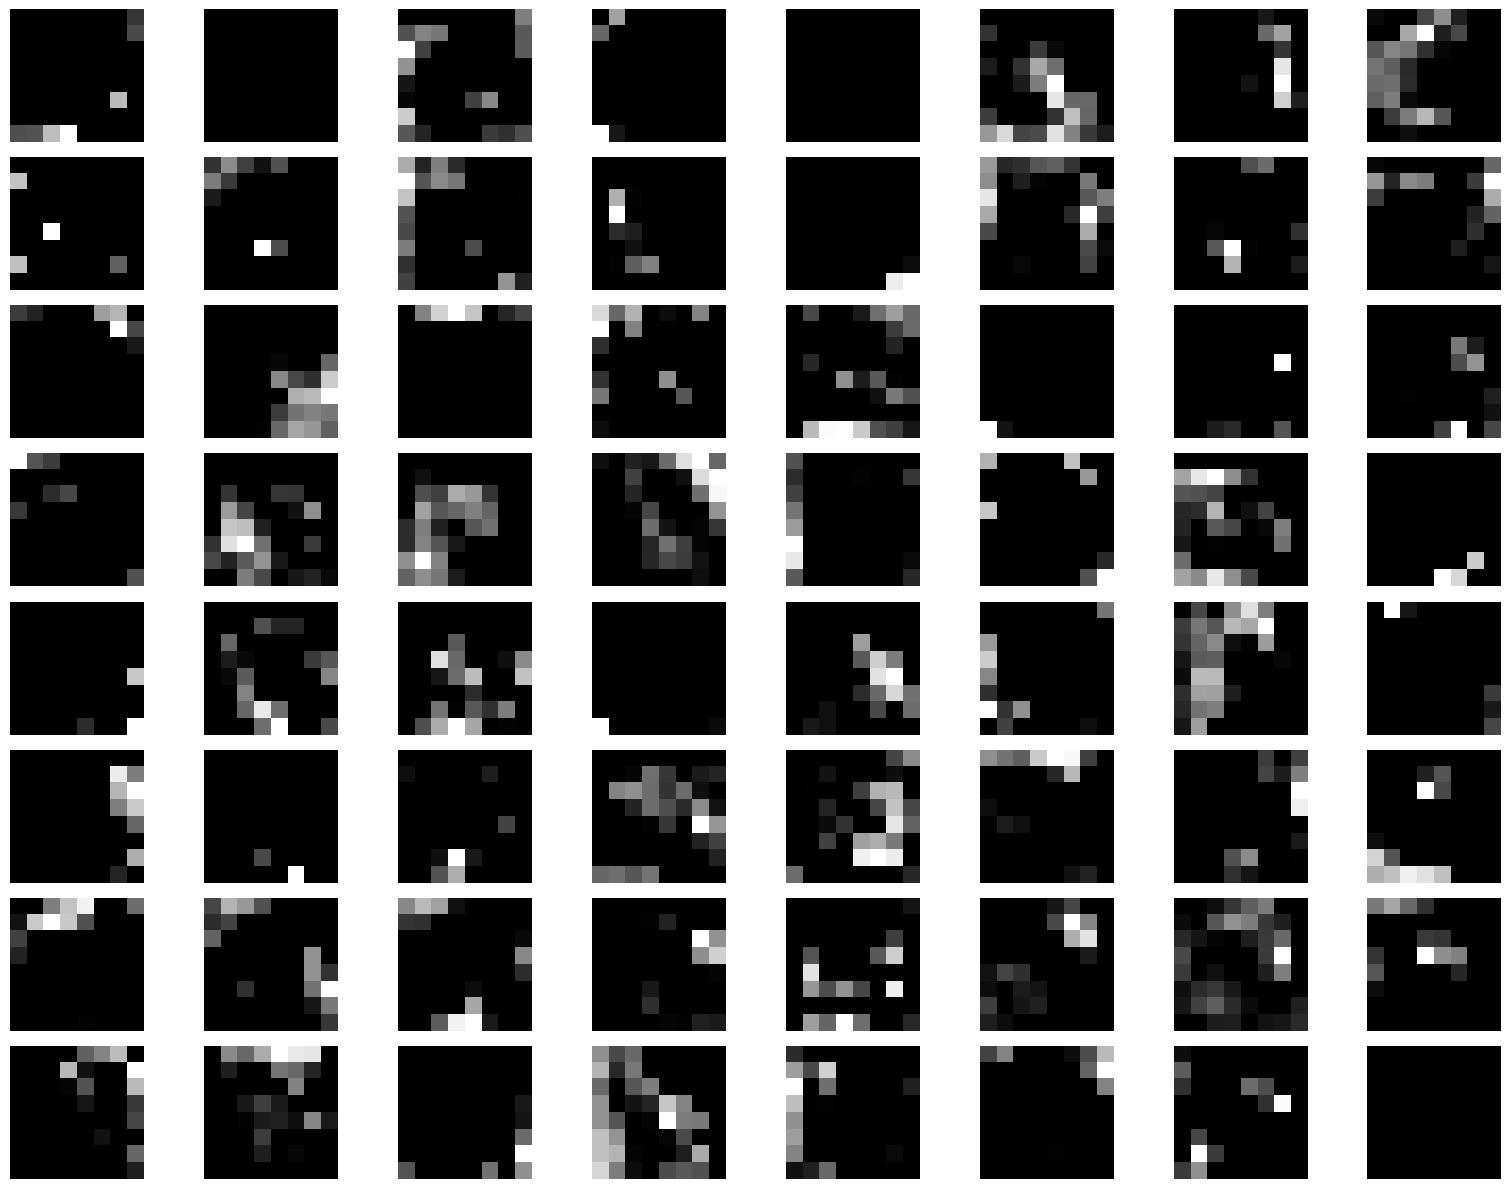

In [34]:
plt.imshow(testX[1000])
print("Class",testY[1000])
getmap(model_base,0, 1000)
getmap(model_base,7, 1000)

# Q3-F

Note: Not visualising intermediate outputs for 3 layers here, as all of these are just minor variations of the base model

### LR = 0.0001 (10x lower than default)

In [35]:
model_lr_smol = Sequential()
model_lr_smol.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_lr_smol.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_smol.add(MaxPooling2D((2,2)))
model_lr_smol.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_smol.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_smol.add(MaxPooling2D((2,2)))
model_lr_smol.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_smol.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_smol.add(MaxPooling2D((2,2)))
model_lr_smol.add(Flatten())
model_lr_smol.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_lr_smol.add(Dense(10, activation='softmax'))
opt_lr_smol = SGD(learning_rate=0.0001, momentum=0.9)
model_lr_smol.compile(optimizer=opt_lr_smol, loss='categorical_crossentropy', metrics=['accuracy'])
tc_lr_smol = TimeHistory()
model_lr_smol.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_lr_smol])
evaluate_model(model_lr_smol,tc_lr_smol)

Epoch 1/10
782/782 - 6s - loss: 2.0816 - accuracy: 0.2575 - val_loss: 1.9481 - val_accuracy: 0.3014 - 6s/epoch - 8ms/step
Epoch 2/10
782/782 - 5s - loss: 1.8324 - accuracy: 0.3554 - val_loss: 1.7454 - val_accuracy: 0.3812 - 5s/epoch - 6ms/step
Epoch 3/10
782/782 - 5s - loss: 1.6877 - accuracy: 0.4050 - val_loss: 1.6036 - val_accuracy: 0.4361 - 5s/epoch - 6ms/step
Epoch 4/10
782/782 - 5s - loss: 1.5757 - accuracy: 0.4434 - val_loss: 1.5257 - val_accuracy: 0.4558 - 5s/epoch - 6ms/step
Epoch 5/10
782/782 - 5s - loss: 1.4919 - accuracy: 0.4727 - val_loss: 1.4574 - val_accuracy: 0.4818 - 5s/epoch - 6ms/step
Epoch 6/10
782/782 - 5s - loss: 1.4343 - accuracy: 0.4920 - val_loss: 1.3993 - val_accuracy: 0.5097 - 5s/epoch - 6ms/step
Epoch 7/10
782/782 - 5s - loss: 1.3817 - accuracy: 0.5107 - val_loss: 1.3646 - val_accuracy: 0.5198 - 5s/epoch - 6ms/step
Epoch 8/10
782/782 - 5s - loss: 1.3432 - accuracy: 0.5249 - val_loss: 1.3540 - val_accuracy: 0.5170 - 5s/epoch - 7ms/step
Epoch 9/10
782/782 - 5s 

### LR = 0.01 (10x higher than default)

In [36]:
model_lr_big = Sequential()
model_lr_big.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_lr_big.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_big.add(MaxPooling2D((2,2)))
model_lr_big.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_big.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_big.add(MaxPooling2D((2,2)))
model_lr_big.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_big.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_lr_big.add(MaxPooling2D((2,2)))
model_lr_big.add(Flatten())
model_lr_big.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_lr_big.add(Dense(10, activation='softmax'))
opt_lr_big = SGD(learning_rate=0.01, momentum=0.9)
model_lr_big.compile(optimizer=opt_lr_big, loss='categorical_crossentropy', metrics=['accuracy'])
tc_lr_big = TimeHistory()
model_lr_big.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_lr_big])
evaluate_model(model_lr_big,tc_lr_big)

Epoch 1/10
782/782 - 6s - loss: 1.5901 - accuracy: 0.4150 - val_loss: 1.2288 - val_accuracy: 0.5639 - 6s/epoch - 7ms/step
Epoch 2/10
782/782 - 5s - loss: 1.1039 - accuracy: 0.6068 - val_loss: 1.0046 - val_accuracy: 0.6402 - 5s/epoch - 6ms/step
Epoch 3/10
782/782 - 5s - loss: 0.8722 - accuracy: 0.6938 - val_loss: 0.8471 - val_accuracy: 0.7017 - 5s/epoch - 6ms/step
Epoch 4/10
782/782 - 5s - loss: 0.7279 - accuracy: 0.7443 - val_loss: 0.7922 - val_accuracy: 0.7264 - 5s/epoch - 6ms/step
Epoch 5/10
782/782 - 5s - loss: 0.6139 - accuracy: 0.7818 - val_loss: 0.8019 - val_accuracy: 0.7273 - 5s/epoch - 6ms/step
Epoch 6/10
782/782 - 5s - loss: 0.5269 - accuracy: 0.8165 - val_loss: 0.7508 - val_accuracy: 0.7490 - 5s/epoch - 6ms/step
Epoch 7/10
782/782 - 5s - loss: 0.4429 - accuracy: 0.8437 - val_loss: 0.7947 - val_accuracy: 0.7483 - 5s/epoch - 6ms/step
Epoch 8/10
782/782 - 5s - loss: 0.3788 - accuracy: 0.8661 - val_loss: 0.8576 - val_accuracy: 0.7345 - 5s/epoch - 6ms/step
Epoch 9/10
782/782 - 5s 

### Batch = 32 (half of default)

In [39]:
model_b32 = Sequential()
model_b32.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_b32.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b32.add(MaxPooling2D((2, 2)))
model_b32.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b32.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b32.add(MaxPooling2D((2, 2)))
model_b32.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b32.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b32.add(MaxPooling2D((2, 2)))
model_b32.add(Flatten())
model_b32.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_b32.add(Dense(10, activation='softmax'))
opt_b32 = SGD(learning_rate=0.001, momentum=0.9)
model_b32.compile(optimizer=opt_b32, loss='categorical_crossentropy', metrics=['accuracy'])
tc_b32 = TimeHistory()
model_b32.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=2, callbacks=[tc_b32])
evaluate_model(model_b32,tc_b32)

Epoch 1/10
1563/1563 - 9s - loss: 1.6351 - accuracy: 0.4071 - val_loss: 1.3643 - val_accuracy: 0.5057 - 9s/epoch - 6ms/step
Epoch 2/10
1563/1563 - 8s - loss: 1.2717 - accuracy: 0.5479 - val_loss: 1.1834 - val_accuracy: 0.5783 - 8s/epoch - 5ms/step
Epoch 3/10
1563/1563 - 8s - loss: 1.0891 - accuracy: 0.6155 - val_loss: 1.0610 - val_accuracy: 0.6239 - 8s/epoch - 5ms/step
Epoch 4/10
1563/1563 - 8s - loss: 0.9595 - accuracy: 0.6627 - val_loss: 0.9805 - val_accuracy: 0.6606 - 8s/epoch - 5ms/step
Epoch 5/10
1563/1563 - 8s - loss: 0.8529 - accuracy: 0.7010 - val_loss: 0.9402 - val_accuracy: 0.6786 - 8s/epoch - 5ms/step
Epoch 6/10
1563/1563 - 8s - loss: 0.7550 - accuracy: 0.7353 - val_loss: 0.9595 - val_accuracy: 0.6755 - 8s/epoch - 5ms/step
Epoch 7/10
1563/1563 - 7s - loss: 0.6752 - accuracy: 0.7644 - val_loss: 0.8872 - val_accuracy: 0.6942 - 7s/epoch - 5ms/step
Epoch 8/10
1563/1563 - 8s - loss: 0.6038 - accuracy: 0.7895 - val_loss: 0.9064 - val_accuracy: 0.7019 - 8s/epoch - 5ms/step
Epoch 9/

### Batch = 128 (double of default)

In [40]:
model_b128 = Sequential()
model_b128.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_b128.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b128.add(MaxPooling2D((2, 2)))
model_b128.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b128.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b128.add(MaxPooling2D((2, 2)))
model_b128.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b128.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_b128.add(MaxPooling2D((2, 2)))
model_b128.add(Flatten())
model_b128.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_b128.add(Dense(10, activation='softmax'))
opt_b128 = SGD(learning_rate=0.001, momentum=0.9)
model_b128.compile(optimizer=opt_b128, loss='categorical_crossentropy', metrics=['accuracy'])
tc_b128 = TimeHistory()
model_b128.fit(trainX, trainY, epochs=10, batch_size=128, validation_data=(testX, testY), verbose=2, callbacks=[tc_b128])
evaluate_model(model_b128,tc_b128)

Epoch 1/10
391/391 - 5s - loss: 1.9106 - accuracy: 0.3145 - val_loss: 1.6024 - val_accuracy: 0.4292 - 5s/epoch - 12ms/step
Epoch 2/10
391/391 - 3s - loss: 1.5186 - accuracy: 0.4547 - val_loss: 1.4623 - val_accuracy: 0.4852 - 3s/epoch - 9ms/step
Epoch 3/10
391/391 - 3s - loss: 1.3873 - accuracy: 0.5037 - val_loss: 1.3291 - val_accuracy: 0.5246 - 3s/epoch - 8ms/step
Epoch 4/10
391/391 - 4s - loss: 1.2788 - accuracy: 0.5439 - val_loss: 1.2655 - val_accuracy: 0.5504 - 4s/epoch - 9ms/step
Epoch 5/10
391/391 - 4s - loss: 1.1828 - accuracy: 0.5789 - val_loss: 1.1782 - val_accuracy: 0.5796 - 4s/epoch - 10ms/step
Epoch 6/10
391/391 - 3s - loss: 1.1098 - accuracy: 0.6077 - val_loss: 1.1017 - val_accuracy: 0.6096 - 3s/epoch - 9ms/step
Epoch 7/10
391/391 - 3s - loss: 1.0349 - accuracy: 0.6365 - val_loss: 1.0928 - val_accuracy: 0.6135 - 3s/epoch - 8ms/step
Epoch 8/10
391/391 - 4s - loss: 0.9857 - accuracy: 0.6547 - val_loss: 1.0519 - val_accuracy: 0.6254 - 4s/epoch - 10ms/step
Epoch 9/10
391/391 - 

### 25 Epochs (Default=10) (Also reports all epoch accuracies between 10 and 25)

In [41]:
model_25epochs = Sequential()
model_25epochs.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_25epochs.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_25epochs.add(MaxPooling2D((2, 2)))
model_25epochs.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_25epochs.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_25epochs.add(MaxPooling2D((2, 2)))
model_25epochs.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_25epochs.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_25epochs.add(MaxPooling2D((2, 2)))
model_25epochs.add(Flatten())
model_25epochs.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_25epochs.add(Dense(10, activation='softmax'))
opt_25epochs = SGD(learning_rate=0.001, momentum=0.9)
model_25epochs.compile(optimizer=opt_25epochs, loss='categorical_crossentropy', metrics=['accuracy'])
tc_25epochs = TimeHistory()
model_25epochs.fit(trainX, trainY, epochs=25, batch_size=64, validation_data=(testX, testY), verbose=2, callbacks=[tc_25epochs])
evaluate_model(model_25epochs,tc_25epochs)

Epoch 1/25
782/782 - 6s - loss: 1.7595 - accuracy: 0.3598 - val_loss: 1.4575 - val_accuracy: 0.4698 - 6s/epoch - 8ms/step
Epoch 2/25
782/782 - 5s - loss: 1.3589 - accuracy: 0.5137 - val_loss: 1.2452 - val_accuracy: 0.5567 - 5s/epoch - 7ms/step
Epoch 3/25
782/782 - 5s - loss: 1.1784 - accuracy: 0.5825 - val_loss: 1.0901 - val_accuracy: 0.6166 - 5s/epoch - 6ms/step
Epoch 4/25
782/782 - 5s - loss: 1.0425 - accuracy: 0.6351 - val_loss: 1.0196 - val_accuracy: 0.6375 - 5s/epoch - 6ms/step
Epoch 5/25
782/782 - 5s - loss: 0.9474 - accuracy: 0.6680 - val_loss: 1.0078 - val_accuracy: 0.6515 - 5s/epoch - 6ms/step
Epoch 6/25
782/782 - 5s - loss: 0.8706 - accuracy: 0.6968 - val_loss: 0.9124 - val_accuracy: 0.6791 - 5s/epoch - 6ms/step
Epoch 7/25
782/782 - 5s - loss: 0.8018 - accuracy: 0.7198 - val_loss: 0.8825 - val_accuracy: 0.6970 - 5s/epoch - 6ms/step
Epoch 8/25
782/782 - 5s - loss: 0.7373 - accuracy: 0.7427 - val_loss: 0.8730 - val_accuracy: 0.7037 - 5s/epoch - 6ms/step
Epoch 9/25
782/782 - 5s 